In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

import gc_turbulence as g

%matplotlib inline

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2199]:
index = 'r14_01_14a'
cache_path = '/home/aaron/lab/local/processed/' + index + '.hdf5'
cache_path = g.default_processed + index + '.hdf5'

r = g.ProcessedRun(cache_path=cache_path)

u_levels = np.linspace(*np.percentile(r.Uf[...], (1, 99)), num=100)

tf = r.Tf[:, 0, :]
zf = r.Zf[:, 0, :]

In [8]:
def bandpass(signal, cutoff, high_cutoff=False, axis=-1):
    fft = np.fft.rfft(signal, axis=axis)
    freqs = np.fft.rfftfreq(signal.shape[axis], d=0.01)
    
    s = [slice(None) for _ in range(signal.ndim)]
    s[axis] = freqs < cutoff
    rfft = fft.copy()
    rfft[s] = 0
    
    if high_cutoff:
        s[axis] = freqs > high_cutoff
        rfft[s] = 0
        
    rdata = np.fft.irfft(rfft)
    return rdata


def find_nearest_idx(array,value):
    return (np.abs(array-value)).argmin()


def find_closest_peaks(power, freqs, guess_freqs):
    """Given a power spectrum over frequencies `freqs` 
    find the array indices of the power spectrum peaks 
    closest to the guess_freqs.
    """
    # find the maxima in the power spectrum
    maxima = sig.argrelextrema(power, np.greater)

    maxima_freqs = np.zeros(freqs.shape)
    maxima_freqs[maxima] = freqs[maxima]
    
    # determine the peaks as the closest maxima to each of the standing wave frequencies
    peak_indices = [find_nearest_idx(maxima_freqs, f) for f in guess_freqs]
    return peak_indices
    

def extract_standing_signal(velocity, front_index, time, dt):
    # pull out the pre-front signal
    presignal = velocity[:, :, :front_index - 500].mean(axis=0).mean(axis=0)
    
    # bandpass to only permit standing waves
    standing_signal = bandpass(presignal, 0.1, 0.7)
    
    # zero pad and window to increase frequency resolution   
    window = sig.hanning(standing_signal.size)
    extended = np.zeros(standing_signal.size * 20)
    extended[:standing_signal.size] = standing_signal * window
    
    # compute the fft
    extended_freqs = np.fft.rfftfreq(extended.size, d=dt)
    extended_fft = np.fft.rfft(extended)
    extended_power = np.abs(extended_fft)
     
    peak_indices = find_closest_peaks(extended_power, extended_freqs, standing_frequencies)
    standing_waves = reconstruct_waves_fft(extended_fft, extended_freqs, peak_indices, time, window=window)
    
    return standing_waves


def reconstruct_waves_fft(fft, freqs, peak_indices, time, window=None):
    """Construct wave modes given a set of rfft coefficients, 
    corresponding frequencies, indices from which to determine 
    the wave coefficients and a time series over which to
    compute the waves.
    
    The optional window is that used to pre-filter the data 
    before the fft. The default is to assume a rectangular window.
    
    Returns an array of waves, shape [time.size, peak_indices.size]
    """
    # normalisation given use of the rfft
    if window is None:
        norm = 1.0 / fft.size()
    else:       
        norm = 2.0 / window.sum()

    standing_amplitude = fft[peak_indices]
    standing_frequency = freqs[peak_indices]
    
    return reconstruct_waves(standing_amplitude, standing_frequency, time, norm)

def reconstruct_waves(amplitude, frequency, time, norm):
    waves = norm * amplitude[None] * np.exp(2j * np.pi * frequency[None] * time[:, None])
    return waves.real


def extract_cluster_signal(velocity):
    mean_signal = velocity[:].mean(axis=0).mean(axis=0)
    return bandpass(mean_signal, 0.63)


def extract_waves(run):
    front_index = int(np.min(run.ft) / run.dt)
    time = run.T[0, 0, :]
    
    sw = extract_standing_signal(r.U, front_index, time, r.dt).sum(axis=1)
    cs = extract_cluster_signal(r.U)
    
    return cs + sw

f1 = 0.142
standing_frequencies = f1 * np.arange(1, 5)

def plot_standing_frequencies(f1=f1, n=4):
    for n in range(1, n + 1):
        plt.axvline(n * f1, color='k')

4006


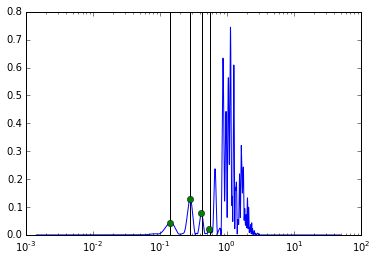

In [295]:
# pull out the pre-front signal
front_index = int(np.min(r.ft) / r.dt)
print front_index
#presignal = r.W[:, :, :front_index - 500].mean(axis=0).mean(axis=0)

presignal = r.W[-1, :, :front_index - 500].mean(axis=0)

time = r.T[0, 0, :]

# bandpass to only permit standing waves
standing_signal = bandpass(presignal, 0.1, 3)

# zero pad and window to increase frequency resolution   
window = sig.hanning(standing_signal.size)
extended = np.zeros(standing_signal.size * 20)
extended[:standing_signal.size] = standing_signal * window

# compute the fft
extended_freqs = np.fft.rfftfreq(extended.size, d=r.dt)
extended_fft = np.fft.rfft(extended)
extended_power = np.abs(extended_fft)

plt.semilogx(extended_freqs, extended_power)
peak_indices = find_closest_peaks(extended_power, extended_freqs, standing_frequencies)

plot_standing_frequencies()
plt.plot(extended_freqs[peak_indices], extended_power[peak_indices], 'o')

(-0.003, 0.003)

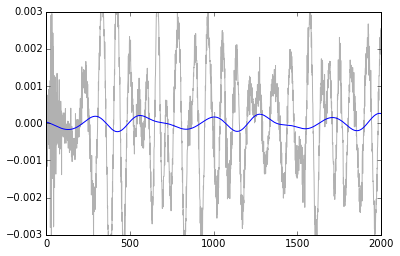

In [296]:
standing_waves = reconstruct_waves_fft(extended_fft, extended_freqs, peak_indices, time, window=window)
cs = extract_cluster_signal(r.W)

plt.plot(r.W[-1, 40, :], alpha=0.3, color='k')
plt.plot(standing_waves.sum(axis=1))
plt.xlim(0, 2000)
plt.ylim(-0.003, 0.003)

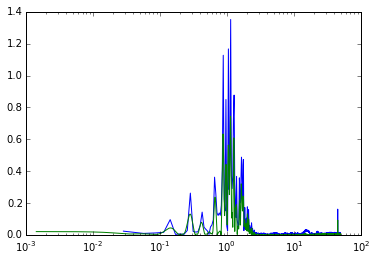

In [383]:
def plot_fft(signal):
    fft = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(signal.size, d=0.01)
    power = np.abs(fft)
    
    plt.semilogx(freqs, power)
    

def plot_smooth_fft(signal):
    window = np.hanning(signal.size)
    
    extended = np.zeros(signal.size * 20)
    extended[:signal.size] = signal * window
    
    fft = np.fft.rfft(extended)
    freqs = np.fft.rfftfreq(extended.size, d=0.01)
    power = np.abs(fft)
    
    plt.semilogx(freqs, power)
    
plot_fft(presignal)  
plot_smooth_fft(presignal)
#plot_smooth_fft(presignal - standing_waves.sum(axis=1)[:3506])

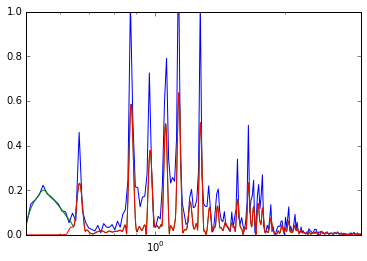

In [384]:
plt.xlim(0.5, 3)
plt.ylim(0, 1)
plot_fft(r.W[:].mean(axis=0).mean(axis=0))
plot_smooth_fft(r.W[:].mean(axis=0).mean(axis=0))
plot_smooth_fft(full_cs.mean(axis=0))

In [322]:
wavesignal = full_cs[:, None, :] + standing_waves.sum(axis=1)[None, None, :]
background = r.W[:, :, :3000].mean(axis=-1)
subdata = r.W - wavesignal - background[:, :, None]

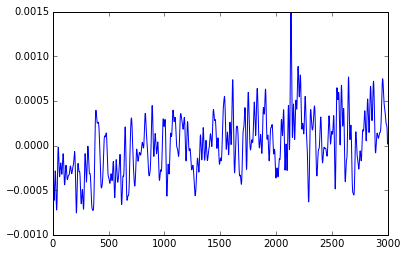

In [333]:
plt.plot(bandpass(subdata[20, 1, :3000], 0, 5))

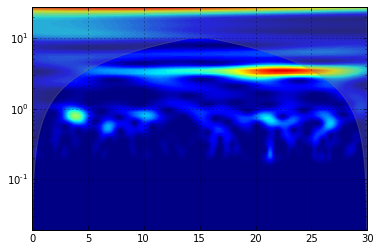

In [334]:
wavelets.WaveletTransform(bandpass(subdata[20, 1, :3000], 0, 5), dt=0.01).plot_power()

<matplotlib.contour.QuadContourSet instance at 0x2afa7baaf290>

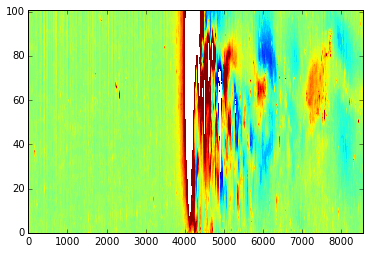

In [327]:
plt.contourf(subdata[:, 10, :], levels=w_levels)

(0.07, 0.7)

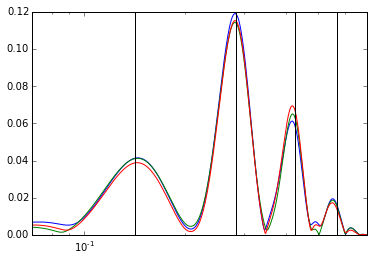

In [288]:
p1 = bandpass(r.W[-1, :20, :3000].mean(axis=0), 0.07, 0.63)
p2 = bandpass(r.W[-1, 40:60, :3000].mean(axis=0), 0.07, 0.63)
p3 = bandpass(r.W[-1, 0:, :3000].mean(axis=0), 0.07, 0.63)

plot_smooth_fft(p1)
plot_smooth_fft(p2)
plot_smooth_fft(p3)

plot_standing_frequencies()

plt.xlim(0.07, 0.7)

<matplotlib.contour.QuadContourSet instance at 0x2afaba4f4878>

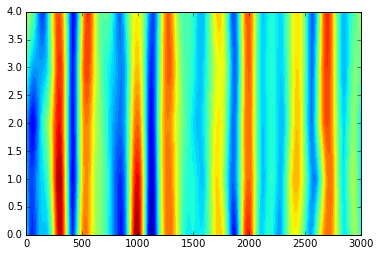

In [286]:
plt.contourf(bandpass(r.W[-1, -10:-5, :3000], 0.07, 0.63, axis=-1), 50)

<matplotlib.contour.QuadContourSet instance at 0x2af90283dc68>

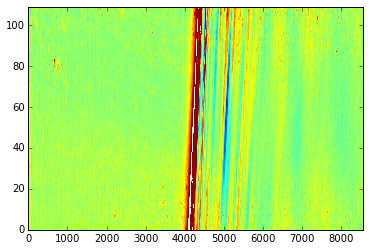

In [14]:
w_levels = np.linspace(-0.01, 0.01)
plt.contourf(r.W[10], levels=w_levels)

In [16]:
cs = bandpass(r.W[:].mean(axis=1), 0.63, axis=-1)

<matplotlib.contour.QuadContourSet instance at 0x2af902287f38>

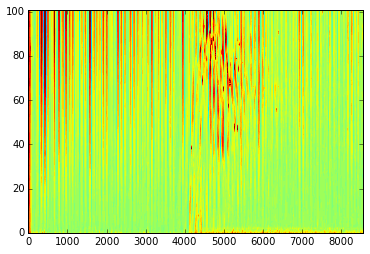

In [17]:
plt.contourf(cs, levels=np.linspace(-0.003, 0.003))

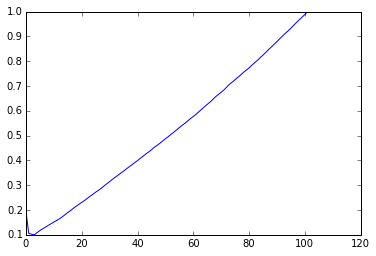

In [18]:
# vertical profile of velocity, normalised to at the upper surface
vertical_profile = np.abs(cs[:, 100:3000]).mean(axis=-1) / np.abs(cs[-1, 100:3000]).mean()
plt.plot(vertical_profile)

In [19]:
# find the scaling between the mean and the upper value in the pre current zone
scaling = np.abs(cs[-1, 100:3000]).mean() / np.abs(cs[:, 100:3000]).mean()

# then use this scaling to determine the upper value across the full time
upper_cs = scaling * cs.mean(axis=0)

# then extend this using the vertical profile
full_cs = vertical_profile[:, None] * upper_cs[None]

<matplotlib.colorbar.Colorbar instance at 0x2af9224e3050>

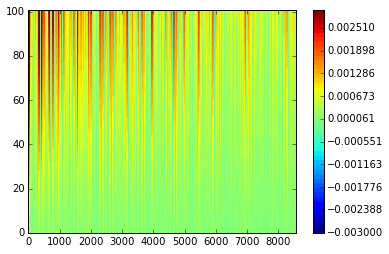

In [20]:
plt.contourf(full_cs, levels=np.linspace(-0.003, 0.003))
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2af92f66e098>

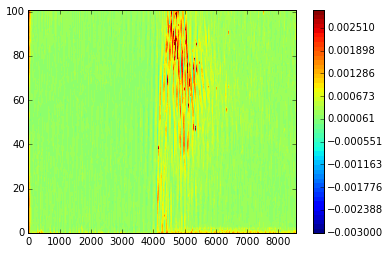

In [21]:
plt.contourf(cs - full_cs, levels=np.linspace(-0.003, 0.003))
plt.colorbar()

In [22]:
bw = bandpass(r.W[:, 10, :], 0.63)

<matplotlib.contour.QuadContourSet instance at 0x2af938315bd8>

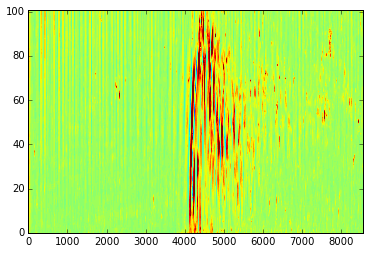

In [23]:
plt.contourf(bw, levels=w_levels)

<matplotlib.contour.QuadContourSet instance at 0x2af950c34b90>

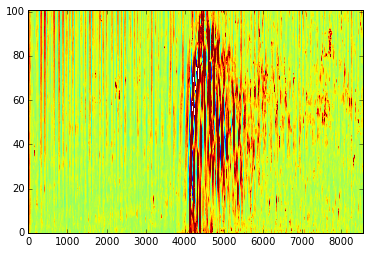

In [24]:
plt.contourf(bw, levels=np.linspace(-0.005, 0.005))

<matplotlib.contour.QuadContourSet instance at 0x2af976c47170>

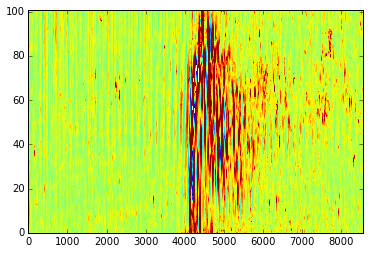

In [25]:
plt.contourf(bw - full_cs, levels=np.linspace(-0.005, 0.005))

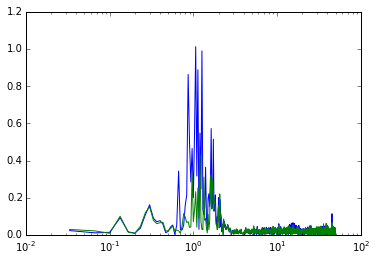

In [26]:
plot_fft(r.W[-10, 10, :3000])
plot_fft((r.W[:, 10] - full_cs)[-10, :3000])


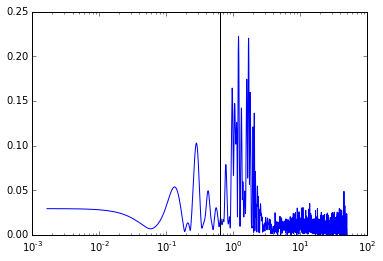

In [155]:
plot_smooth_fft((r.W[:, 10] - full_cs)[-10, :3000])
plt.axvline(0.63, color='k')

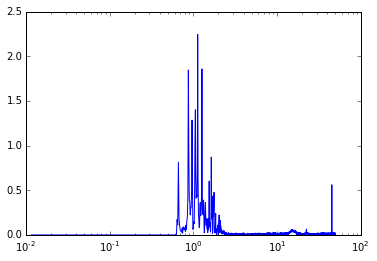

In [28]:
plot_fft(full_cs[-10])

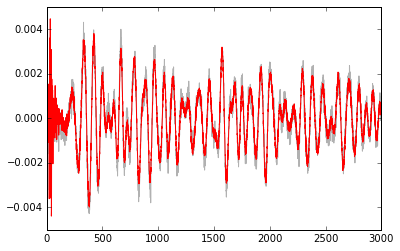

In [29]:
plt.plot(r.W[-1, 50, :3000], 'k', alpha=0.3)
         
plt.plot(full_cs[-1, :3000], 'r')

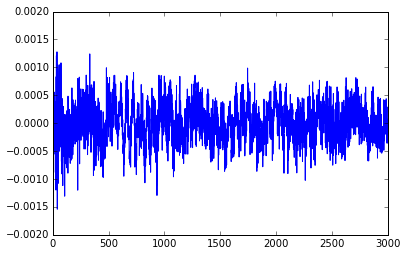

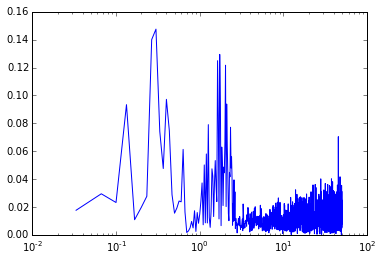

In [30]:
subsignal = (r.W[-1, 50, :3000] - full_cs[-1, :3000])

plt.figure()
plt.plot(subsignal)

plt.figure()
plot_fft(subsignal)

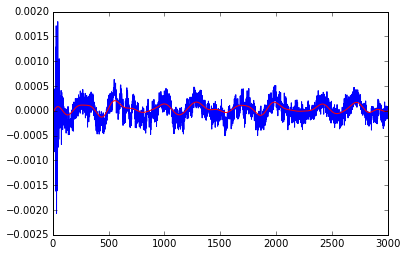

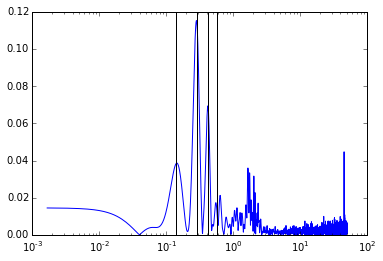

In [31]:
remainder = (r.W[-1, :, :3000] - full_cs[-1, None, :3000])
plt.plot(remainder.mean(axis=0))
plt.plot(r.W[:, :, :3000].mean(axis=0).mean(axis=0) - full_cs.mean(axis=0)[:3000], 'r')

plt.figure()
plot_smooth_fft(remainder.mean(axis=0))
plot_standing_frequencies()

In [32]:
sw = extract_standing_signal(remainder.mean(axis=0)[None, None, :], 3500, r.T[0,0,:], 0.01)

(-0.0005, 0.0005)

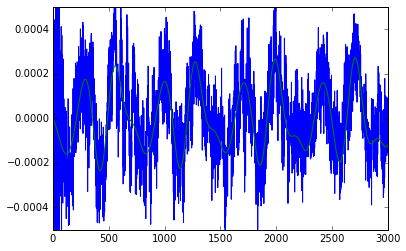

In [33]:
plt.plot(remainder.mean(axis=0))
plt.plot(sw.sum(axis=1))
plt.xlim(0, 3000)
plt.ylim(-0.0005, 0.0005)

In [34]:
bsw = bandpass(r.W[:, :, :3000].mean(axis=1), 0.1, 0.65)

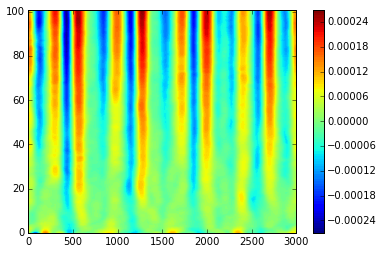

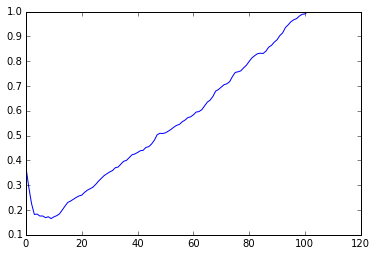

In [35]:
plt.contourf(bsw, 100)
plt.colorbar()

plt.figure()
vertical_w = np.abs(bsw).mean(axis=1) / np.abs(bsw[-1]).mean()
plt.plot(vertical_w)

(102, 8576)


(0, 3000)

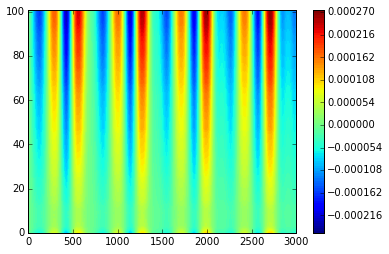

In [36]:
ww = vertical_w[:, None] * sw.sum(axis=1)
print ww.shape
plt.contourf(ww, 100)
plt.colorbar()
plt.xlim(0, 3000)

<matplotlib.contour.QuadContourSet instance at 0x2af9a0806b00>

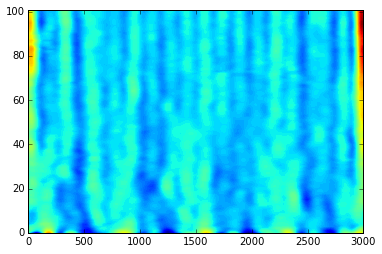

In [37]:
plt.contourf(bsw - ww[:, :3000], 100)

<matplotlib.contour.QuadContourSet instance at 0x2af9984f4fc8>

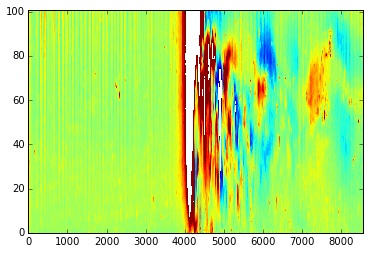

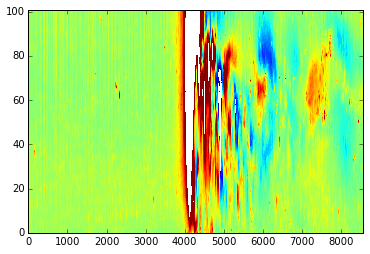

In [38]:
waveless = r.W[:, 10] - ww - full_cs
plt.contourf(r.W[:, 10], levels=w_levels)

plt.figure()
plt.contourf(waveless, levels=w_levels)

<matplotlib.contour.QuadContourSet instance at 0x2af9a00072d8>

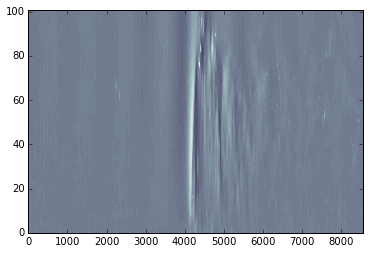

In [39]:
plt.contourf(bandpass(waveless, 0.1), levels=np.linspace(-0.05, 0.05), cmap=plt.cm.bone)

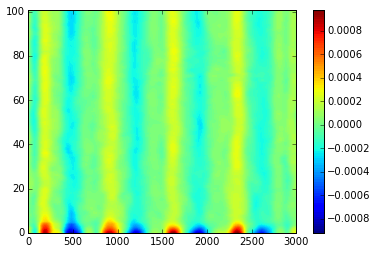

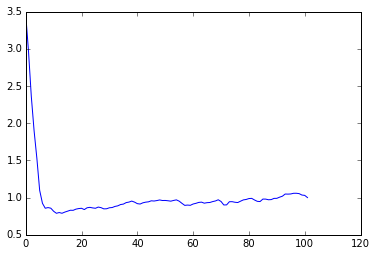

In [40]:
bsv = bandpass(r.V[:, :, :3000].mean(axis=1), 0.1, 0.65)
plt.contourf(bsv, 100)
plt.colorbar()

plt.figure()
plt.plot(np.abs(bsv).mean(axis=1) / np.abs(bsv[-1]).mean())

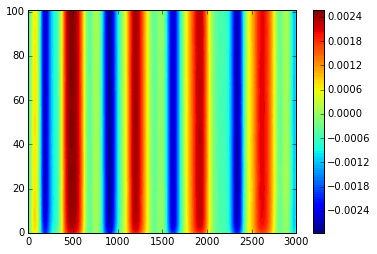

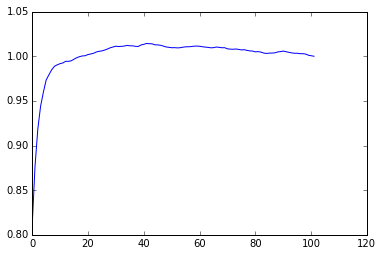

In [41]:
bsu = bandpass(r.U[:, :, :3000].mean(axis=1), 0.1, 0.65)
plt.contourf(bsu, 100)
plt.colorbar()

plt.figure()
plt.plot(np.abs(bsu).mean(axis=1) / np.abs(bsu[-1]).mean())

## Filtering with the radon / ridgelet transform

<matplotlib.contour.QuadContourSet instance at 0x2af9c8c0acb0>

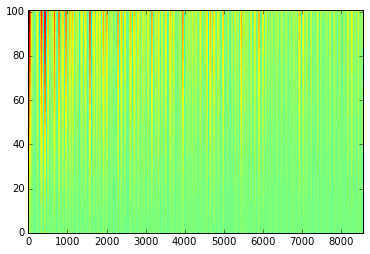

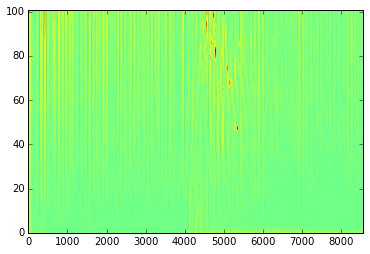

In [42]:
plt.figure()
plt.contourf(full_cs, 50)

plt.figure()
plt.contourf(cs, 50)

In [43]:
csw = bandpass(r.W[:, :, :].mean(axis=1), 0.65, 3)

<matplotlib.contour.QuadContourSet instance at 0x2af9d51de0e0>

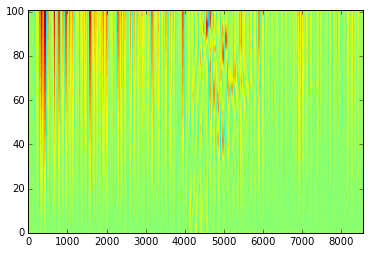

In [44]:
plt.contourf(csw, 50)

In [87]:
import scipy.ndimage as ndi
import scipy.interpolate as interp

<matplotlib.colorbar.Colorbar instance at 0x2af9f9537c20>

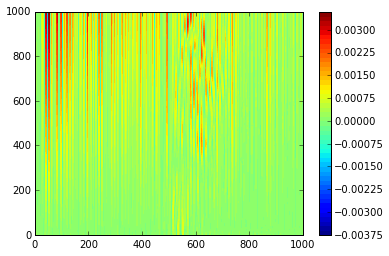

In [118]:
zi = np.linspace(0.006, 0.12, 1000)
ti = np.linspace(0, 80, 1000)

cs_field = interp.interp2d(r.T[0, 0, :], r.Z[:, 0, 0], csw)
data = cs_field(ti, zi)
plt.contourf(data, 50)
plt.colorbar()

In [93]:
from skimage.transform import radon, iradon

theta=np.linspace(-5, 5, 100)
sinogram = radon(data, theta, circle=False)

<matplotlib.contour.QuadContourSet instance at 0x2af9f465afc8>

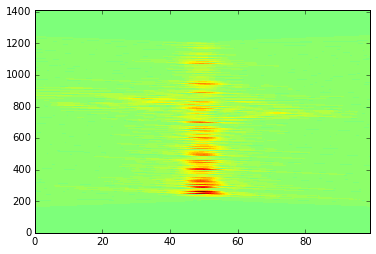

In [94]:
plt.contourf(sinogram, 50)

<matplotlib.contour.QuadContourSet instance at 0x2afa3c7e5c20>

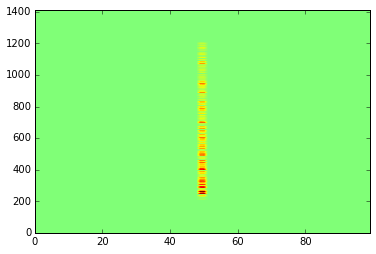

In [134]:
filtered_sinogram = sinogram.copy()
filtered_sinogram[:, np.abs(theta) > 0.1] = 0
plt.contourf(filtered_sinogram, 100)

In [135]:
rdata = iradon(filtered_sinogram, theta=theta)

<matplotlib.colorbar.Colorbar instance at 0x2afa583f4050>

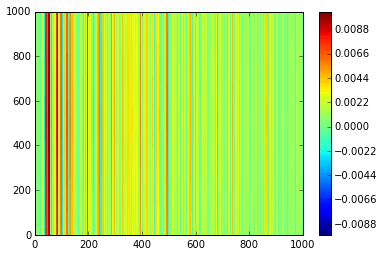

In [136]:
plt.contourf(rdata, 100)
plt.colorbar()

In [106]:
import wavelets
wt = wavelets.WaveletTransform(filtered_sinogram, axis=1)

In [108]:
wtpower = wt.wavelet_power

<matplotlib.contour.QuadContourSet instance at 0x2af9f8c9cab8>

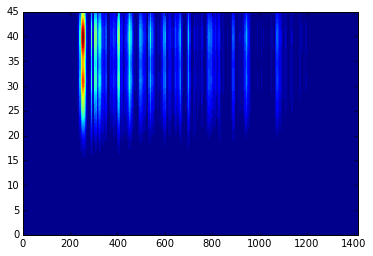

In [114]:
plt.contourf(wtpower.mean(axis=-1), 50)

In [146]:
# need to scale the rdata back
srdata = rdata.mean(axis=0) / np.sqrt(np.mean(np.square(rdata)))

<matplotlib.colorbar.Colorbar instance at 0x2afa5a7aa518>

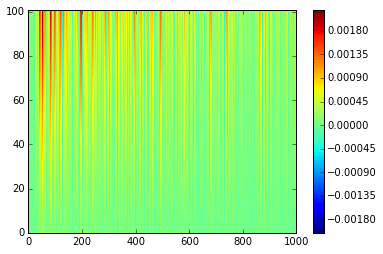

In [147]:
plt.contourf(vertical_profile[:, None] * srdata[None] * np.sqrt(np.mean(np.square(full_cs))), 100)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2afa64852518>

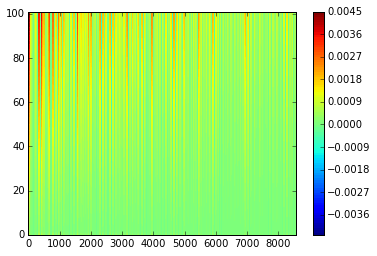

In [148]:
plt.contourf(full_cs, 100)
plt.colorbar()

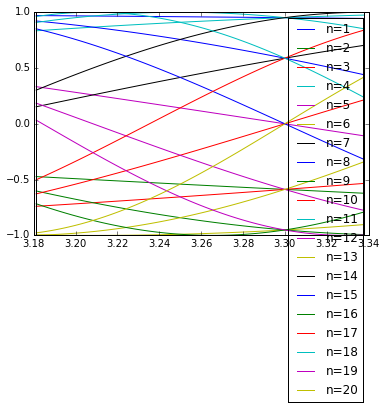

In [1890]:
d = 0.25
g = 9.81

def k(f):
    return (g * d) ** .5 / (2 * np.pi * f)

xmin = r.X[0, :, 0].min()
xmax = r.X[0, :, 0].max()

x = np.linspace(xmin, xmax, 100)
x = r.X[0, :, 0]

for i in range(20):
    n = i + 1
    plt.plot(x, np.sin(np.pi * n * x / L), label='n={}'.format(n))
    
plt.axvline(xmin, color='k')
plt.axvline(xmax, color='k')
plt.legend()

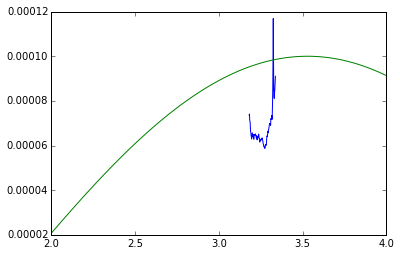

In [212]:
plt.plot(r.X[0, :, 0], np.mean(np.sqrt(np.mean(bandpass(r.W[:, :, :3000], 0.21, 0.35, axis=-1) ** 2, axis=-1)), axis=0))
plt.plot(x, -np.cos(k(0.28) * x) / 10000)

<matplotlib.contour.QuadContourSet instance at 0x2afa8c630950>

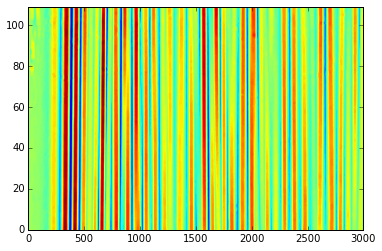

In [221]:
plt.contourf(bandpass(r.W[-1, :, :3000], 0.1, 3, axis=-1), 100)

In [211]:
np.mean(np.sqrt(np.mean(bandpass(r.W[:, :, :3000], 0.21, 0.35, axis=-1) ** 2, axis=-1)), axis=0).shape

(110,)

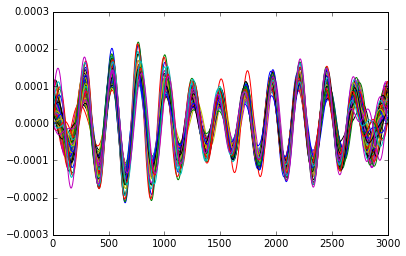

In [265]:
plt.plot(bandpass(r.W[-1, :, :3000], 0.35, 0.5, axis=-1).T);

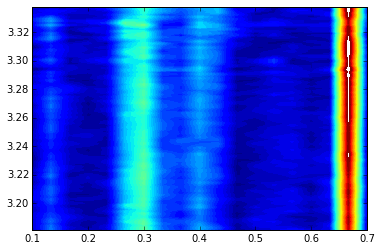

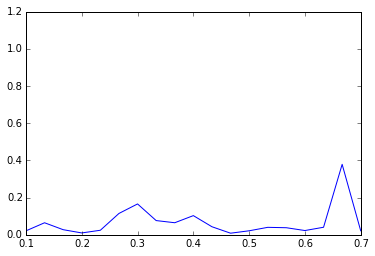

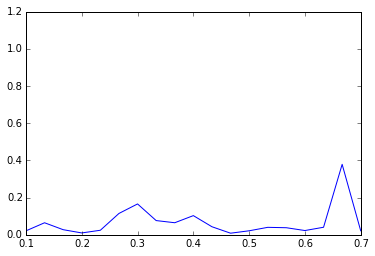

In [238]:
afft = np.fft.rfft(r.W[-1, :, :3000], axis=-1)

afreq = np.fft.rfftfreq(3000, 0.01)
x = r.X[0, :, 0]
F, X = np.meshgrid(afreq, x)
plt.xlim(0.1, 0.7)
plt.contourf(F, X, np.abs(afft), levels=np.linspace(0, 0.4))

plt.figure()
plt.plot(afreq, np.abs(afft[10]))
plt.xlim(0.1, 0.7)

plt.figure()
plot_fft(r.W[-1, 10, :3000])
plt.xlim(0.1, 0.7)
plt.xscale('linear')

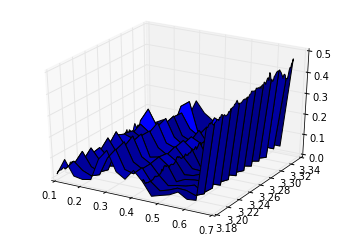

In [263]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(F[:, 3:21], X[:, 3:21], np.abs(afft[:, 3:21]))

1.33333333333


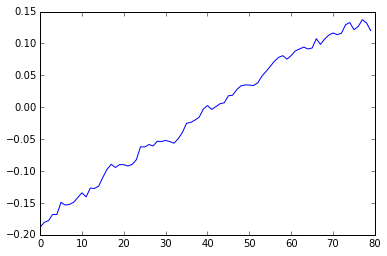

In [397]:

plt.plot(afft[:80, 40])
print afreq[40]

0.414753547384


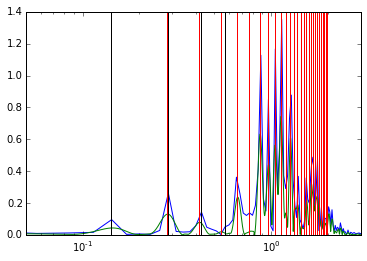

In [650]:
L = 5.5

def full_frequency(n):
    k = np.pi * n / L
    w2 = g * k * np.tanh(k * d)
    return np.sqrt(w2) / (2 * np.pi)

print full_frequency(3)

plot_fft(presignal)

plot_smooth_fft(presignal)
plt.xlim(0.05, 3)

for n in range(28):
    plt.axvline(full_frequency(n + 1), color='r')

plot_standing_frequencies()

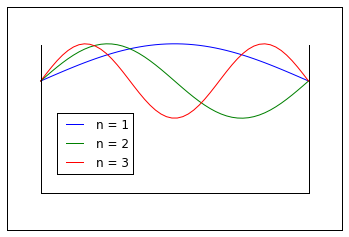

In [377]:
plt.figure()

x = np.linspace(0, 10)

m1 = np.sin(x * np.pi * 1. / 10)
m2 = np.sin(x * np.pi * 2. / 10)
m3 = np.sin(x * np.pi * 3. / 10)

plt.plot(x, m1, label='n = 1')
plt.plot(x, m2, label='n = 2')
plt.plot(x, m3, label='n = 3')

plt.legend(loc=(0.15, 0.25))

plt.axvline(0, 0.17, 0.83, color='k')
plt.axvline(10, 0.17, 0.83, color='k')

plt.axhline(-3, 0.1, 0.9, color='k')

plt.xlim(-1.25, 11.25)
plt.ylim(-4, 2)

plt.xticks(())
plt.yticks(());

In [590]:
signal = r.U[-1, :, :3000]
x = r.X[-1, :, 0]

window = sig.hamming(3000)

extended = np.zeros((signal.shape[0], 3000 * 20))
extended[:, :3000] = signal * window

efreq = np.fft.rfftfreq(3000 * 20, d=0.01)
efft = np.fft.rfft(extended, axis=-1)
epower = np.abs(efft)

print x.shape
print efreq.shape
print epower.shape

ffti = interp.RectBivariateSpline(x, efreq, epower)

(110,)
(30001,)
(110, 30001)


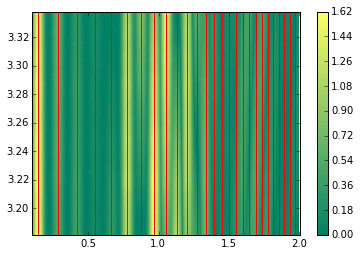

In [1964]:
lfreq = 1 / np.logspace(1, -0.3, 15000)
X, F = np.meshgrid(x, lfreq, indexing='ij')
plt.contourf(F, X, ffti(x, lfreq), 100, cmap=plt.cm.summer)

plt.colorbar()

def plot_all_frequencies(n, **kwargs):
    scaling = kwargs.pop('scaling', 1.008)
    for i in range(n):
        plt.axvline(scaling * full_frequency(i + 1), **kwargs)
        
plot_all_frequencies(28, color='r')

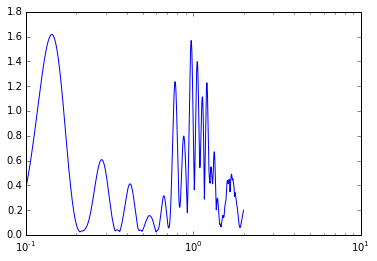

In [1055]:
plt.semilogx(lfreq, ffti(x, lfreq).max(axis=0))

In [607]:
standing_frequencies = np.array([full_frequency(i+1) for i in range(100)])
# don't look for peaks, just find the indices that the standing_frequencies are found at
standing_indices = np.abs(efreq[:, None] - standing_frequencies).argmin(axis=0)

norm = 2 / window.sum()
amplitude = efft[:, standing_indices]
frequency = efreq[standing_indices]
frequency = standing_frequencies

waves = norm * amplitude.T[:, :, None] * np.exp(2j * np.pi * frequency[:, None, None] * time[None, None, :])

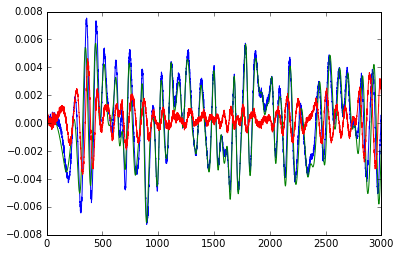

In [608]:
sw = waves[:].sum(axis=0)[:, :3000].real

plt.plot(signal.mean(axis=0))
plt.plot(sw.mean(axis=0))
plt.plot(signal.mean(axis=0) - sw.mean(axis=0))

In [609]:
standing_frequencies.max()

3.7674563298793289

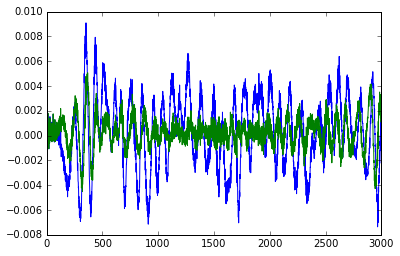

In [610]:
ix=0
plt.plot(signal[ix])
plt.plot(signal[ix] - sw[ix])

<matplotlib.contour.QuadContourSet instance at 0x2afd3e124518>

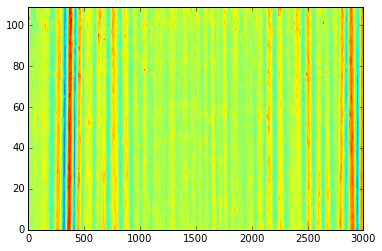

In [611]:
plt.contourf(signal - sw, 100)

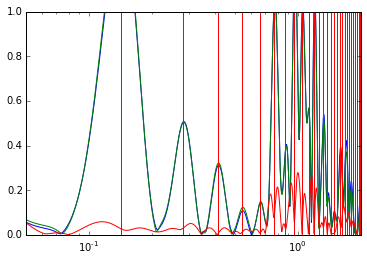

In [878]:
plot_smooth_fft(signal[55])
plot_smooth_fft(signal.mean(axis=0))
plot_smooth_fft((signal - sw).mean(axis=0))
plt.xlim(0.05, 2)
plt.ylim(0, 1)

plot_all_frequencies(28)

(0, 1)

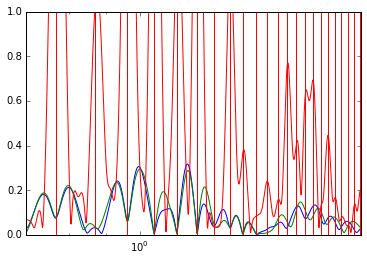

In [639]:
plot_smooth_fft((signal - sw)[10])
plot_smooth_fft((signal - sw)[50])

plot_smooth_fft((r.U[-1, :, 3000:] - swa).mean(axis=0))

#plot_smooth_fft((signal - sw)[50])


plot_all_frequencies(28)


plt.xlim(0.7, 2)
plt.ylim(0, 1)

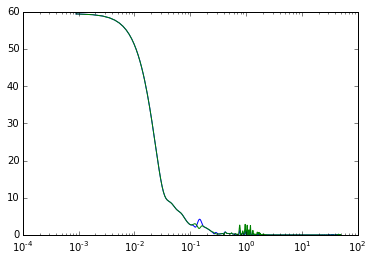

In [615]:
plot_smooth_fft(r.U[-1, :, 3000:].mean(axis=0))
swa = waves[:].sum(axis=0)[:, 3000:].real
plot_smooth_fft((r.U[-1, :, 3000:] - swa).mean(axis=0))

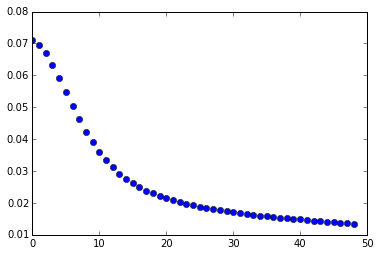

In [648]:
plt.plot(np.diff(full_frequency(np.arange(50))) / 2, 'o')

for successive (increasing) standing frequencies
    take measured power peak as initial amplitude
    take fft phase as the phase (assume doesn't change)
    vary amplitude until the power is minimised
    subtract optimum amplitude from the power
    use this subtracted power in the next iteration

(0, 4)

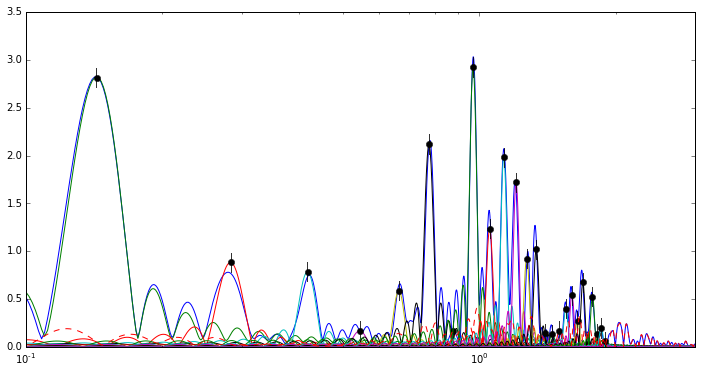

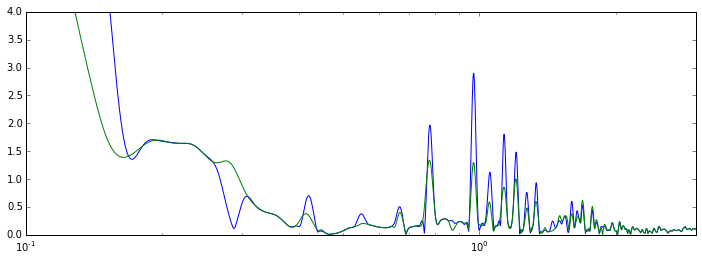

In [1185]:
def construct_wave(amplitude, f, length):
    return amplitude * np.exp(2j * np.pi * f * np.arange(length) * 0.01)

def subtract_amplitude(power, amplitude, f, size, window):
    wave = (2 / window.sum()) * construct_wave(amplitude, f, window.size) * window
    return power - np.abs(np.fft.rfft(wave, size))

def wave_fft(amplitude, f, size, window):
    wave = (2 / window.sum()) * construct_wave(amplitude, f, window.size) * window
    return np.fft.rfft(wave, size)

def subtract_amplitude_fft(fft, amplitude, f, size, window):
    return fft - wave_fft(amplitude, f, size, window)

def minimise_this(amplitude, fft, f, phase, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitude, f, size, window))

def minimise_power(f, fft, freqs, size, window):
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))[0]
    idx = np.abs(freqs - f).argmin()
    
    where = idx
    
    amplitude = power[where]
    # get phase from the fft (assume it doesn't change)
    phase = np.angle(fft[where])
    fmin = freqs[where]
        
    minim = opt.minimize(minimise_this, x0=amplitude, args=(fft, fmin, phase, size, window), 
                         bounds=[(0, amplitude)])
    opt_amplitude = minim.x[0]
    
    camplitude = opt_amplitude * np.exp(1j * phase)
    
    return camplitude, fmin, wave_fft(camplitude, freqs[where], size, window)


size = signal.shape[-1] * 20
window = sig.boxcar(signal.shape[-1])

original = signal[0]
windowed = original * window
fft = np.fft.rfft(windowed, size)
freqs = np.fft.rfftfreq(size, d=0.01)

plt.figure(figsize=(12, 6))
plt.semilogx(freqs, np.abs(fft))

#plot_all_frequencies(15, 'k')

sub_fft = fft.copy()
amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.complex)
peak_ffts = np.zeros((standing_frequencies.size, freqs.size), np.complex)

for i, f in enumerate(standing_frequencies[:25]):
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power(f * 1.008, sub_fft, freqs, size, window) 

    sub_fft = sub_fft - peak_ffts[i]
    plt.semilogx(freqs, np.abs(peak_ffts[i]))
    
    a = np.abs(amplitudes[i])
    ymax = plt.axis()[-1]
    plt.axvline(f * 1.008, (a - 0.1) / ymax, (a + 0.1) / ymax, color='k', alpha=0.8)
    plt.plot(frequencies[i], np.abs(amplitudes[i]), 'ko')

plt.semilogx(freqs, np.abs(sub_fft), 'r--')
plt.xlim(0.1, 3)

plt.figure(figsize=(12, 4))
wp = (2 / window.sum()) * construct_wave(amplitudes[:, None], frequencies[:, None], 8000).real
plot_smooth_fft(r.U[-1, 0, :8000])
plot_smooth_fft(r.U[-1, 0, :8000] - wp.sum(axis=0)[:8000])
plt.xlim(0.1, 3)
plt.ylim(0, 4)

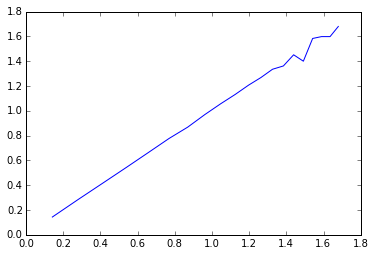

In [1121]:
plt.plot(standing_frequencies[:20], frequencies[:20])

(0, 8)

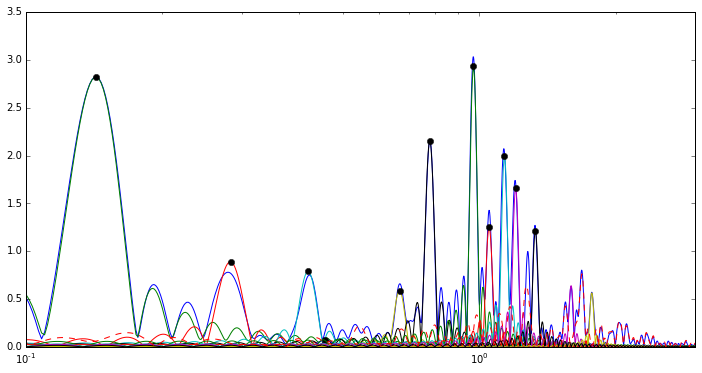

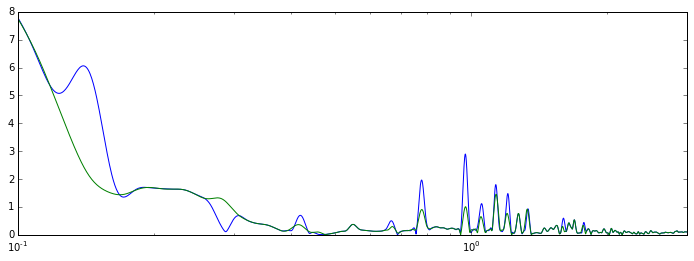

In [1186]:
def minimise_this_all((amplitude, f, phase), fft, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitude, f, size, window))


def minimise_power_all(f, fft, freqs, size, window, bounds=None):
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))
    idx = np.abs(freqs - f).argmin()
    
    amplitude = power[idx]
    # get phase from the fft (assume it doesn't change)
    phase = np.angle(fft[idx])
        
    if bounds is not None:
        dp = 0.1
        bounds = [(0, amplitude), bounds, (phase - dp, phase + dp)]
    minim = opt.minimize(minimise_this_all, x0=(amplitude, freqs[peak], phase), args=(fft, size, window), bounds=bounds)
    opt_amplitude = minim.x[0]
    opt_freq = minim.x[1]
    opt_phase = minim.x[2]
    
    camplitude = opt_amplitude * np.exp(1j * opt_phase)
    
    return camplitude, opt_freq, wave_fft(camplitude, opt_freq, size, window)

a, f, mft = minimise_power_all(full_frequency(2), fft, freqs, size, window)
plt.figure(figsize=(12, 6))
plt.semilogx(freqs, np.abs(fft))
#plt.semilogx(freqs, np.abs(mft))

sub_fft = fft.copy()
amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.complex)
peak_ffts = np.zeros((standing_frequencies.size, freqs.size), np.complex)

for i, f in enumerate(standing_frequencies[:13]):
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_all(f, sub_fft, freqs, size, window) 
    sub_fft = sub_fft - peak_ffts[i]
    plt.semilogx(freqs, np.abs(peak_ffts[i]))
    plt.plot(frequencies[i], np.abs(amplitudes[i]), 'ko')
    
plt.semilogx(freqs, np.abs(sub_fft), 'r--')
plt.xlim(0.1, 3)

plt.figure(figsize=(12, 4))
wp = (2 / window.sum()) * construct_wave(amplitudes[:, None], frequencies[:, None], 8000).real
plot_smooth_fft(r.U[-1, 0, :8000])
plot_smooth_fft(r.U[-1, 0, :8000] - wp.sum(axis=0)[:8000])
plt.xlim(0.1, 3)
plt.ylim(0, 8)

(0, 8)

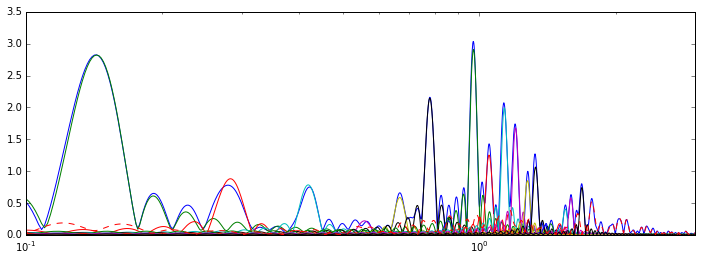

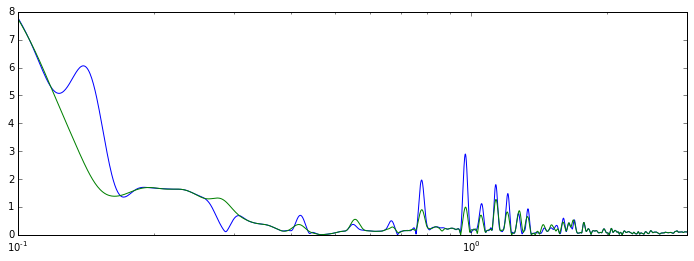

In [1187]:
def minimise_this_phase((amplitude, phase), f, fft, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_fft(fft, amplitude, f, size, window))


def minimise_power_phase(f, fft, freqs, size, window):
    power = np.abs(fft)
    peak = find_closest_peaks(power, np.array(freqs), guess_freqs=np.array([f]))
    idx = np.abs(freqs - f).argmin()
    
    amplitude = power[idx]
    phase = np.angle(fft[idx])
        
    # we can send either f, freqs[peak] or freqs[idx] into the minimiser.
    fmin = freqs[peak]
    minim = opt.minimize(minimise_this_phase, x0=(amplitude, phase), args=(fmin, fft, size, window))
    opt_amplitude = minim.x[0]
    opt_phase = minim.x[1]
    
    camplitude = opt_amplitude * np.exp(1j * opt_phase)
    
    return camplitude, fmin, wave_fft(camplitude, fmin, size, window)

a, fmin, mft = minimise_power_phase(full_frequency(2), fft, freqs, size, window)
plt.figure(figsize=(12, 4))
plt.semilogx(freqs, np.abs(fft))
#plt.semilogx(freqs, np.abs(mft))

#sub_power = np.abs(fft).copy()
sub_fft = fft.copy()

amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.complex)
peak_ffts = np.zeros((standing_frequencies.size, freqs.size), np.complex)

for i, f in enumerate(standing_frequencies[:20]):
    #sub_fft = sub_power * np.exp(1j * np.angle(fft))
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_phase(f, sub_fft, freqs, size, window)
    sub_fft = sub_fft - peak_ffts[i]
    #sub_power = np.abs(sub_power - np.abs(peak_ffts[i]))
    plt.semilogx(freqs, np.abs(peak_ffts[i]))
    #plt.plot(fmin, np.abs(amplitudes[i]), 'ko')
    
plt.semilogx(freqs, np.abs(sub_fft), 'r--')
plt.xlim(0.1, 3)
#plt.semilogx(freqs, np.abs(peak_ffts.sum(axis=0)))

plt.figure(figsize=(12, 4))
wp = (2 / window.sum()) * construct_wave(amplitudes[:, None], frequencies[:, None], 8000).real
plot_smooth_fft(r.U[-1, 0, :8000])
plot_smooth_fft(r.U[-1, 0, :8000] - wp.sum(axis=0)[:8000])
plt.xlim(0.1, 3)
plt.ylim(0, 8)

(0, 8)

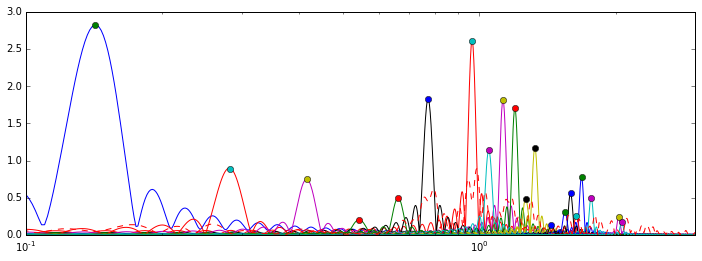

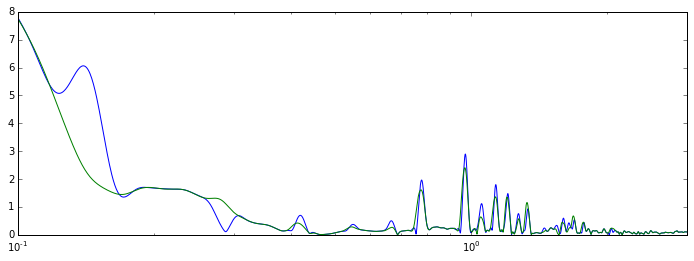

In [1188]:
sub_fft = fft.copy()

#plt.semilogx(freqs, np.abs(sub_fft))

amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.complex)
peak_ffts = np.zeros((standing_frequencies.size, freqs.size), np.complex)

sorted_peaks = np.abs(fft[np.abs(standing_frequencies[:, None] - freqs).argmin(axis=1)]).argsort()[::-1]

plt.figure(figsize=(12, 4))

for i, f in enumerate(standing_frequencies[sorted_peaks][:20]):
    
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_all(f, sub_fft, freqs, size, window, bounds=(f-0.005,f+0.005))
    #amplitudes[i], peak_ffts[i] = minimise_power_phase(f, sub_fft, freqs, size, window)

    sub_fft = sub_fft - peak_ffts[i]
    
    ffit = frequencies[i].real
    
    #print i, ffit, np.abs(amplitudes[i])
    
    plt.semilogx(freqs, np.abs(peak_ffts[i]))
    
    plt.plot(ffit, np.abs(amplitudes[i]), 'o')

plt.semilogx(freqs, np.abs(sub_fft), 'r--')
plt.xlim(0.1, 3)

plt.figure(figsize=(12, 4))
wp = (2 / window.sum()) * construct_wave(amplitudes[:, None], frequencies[:, None], 8000).real
plot_smooth_fft(r.U[-1, 0, :8000])
plot_smooth_fft(r.U[-1, 0, :8000] - wp.sum(axis=0)[:8000])
plt.xlim(0.1, 3)
plt.ylim(0, 8)

(0.05, 3)

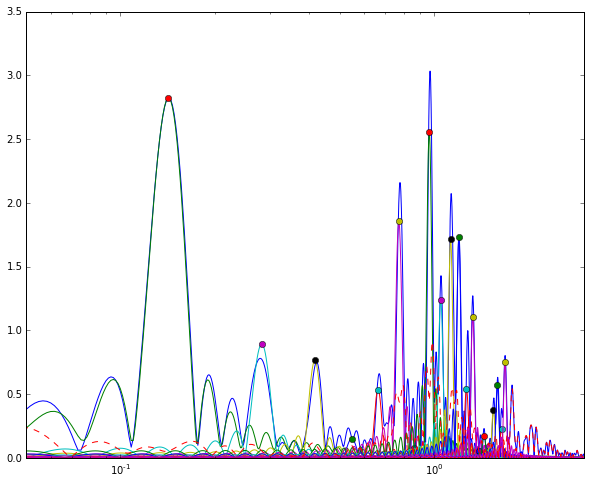

In [1189]:
sub_fft = fft.copy()

plt.figure(figsize=(10, 8))
plt.semilogx(freqs, np.abs(sub_fft))

amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.complex)
peak_ffts = np.zeros((standing_frequencies.size, freqs.size), np.complex)

sorted_peaks = np.abs(fft[np.abs(standing_frequencies[:, None] - freqs).argmin(axis=1)]).argsort()[::-1]

for i, f in enumerate(standing_frequencies[:20]):
    
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_all(f, sub_fft, freqs, size, window, bounds=(f-0.005,f+0.005))
    #amplitudes[i], peak_ffts[i] = minimise_power_phase(f, sub_fft, freqs, size, window)

    sub_fft = sub_fft - peak_ffts[i]
    
    ffit = frequencies[i].real
    
    plt.semilogx(freqs, np.abs(peak_ffts[i]))
    
    plt.plot(ffit, np.abs(amplitudes[i]), 'o')

plt.semilogx(freqs, np.abs(sub_fft), 'r--')
plt.xlim(0.05, 3)

In [990]:
minimise_power_all(0.14, fft, freqs, size, window)

((0.061489883935834343+1.4387504640367059j),
 0.14265784122044942,
 array([  7.02043838e-03 +0.00000000e+00j,
          6.62272997e-03 -8.73417426e-04j,
          5.68044987e-03 -1.12220530e-03j, ...,
         -2.15700678e-12 +2.73471350e-13j,
         -2.06984863e-12 +1.45099319e-13j,  -2.04124738e-12 +0.00000000e+00j]))

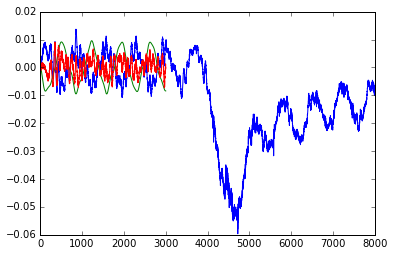

In [1059]:
aw = (2 / window.sum()) * construct_wave(amplitudes[:5, None], frequencies[:5, None], 8000).real.sum(axis=0)
plt.plot(r.U[-1, 0, :8000] - aw)
plt.plot(aw[:3000])
plt.plot(original)

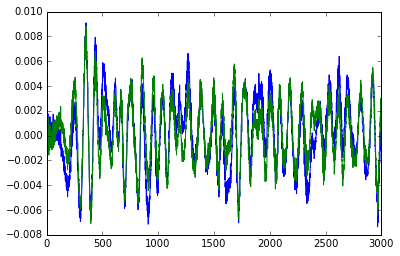

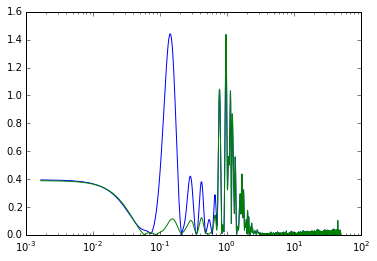

In [1049]:
mwaves = construct_wave(amplitudes[:5, None], standing_frequencies[:5, None], 3000)
amwaves = (2 / window.sum()) * mwaves.sum(axis=0).real

plt.plot(original)
plt.plot(original - amwaves)

plt.figure()

plot_smooth_fft(original)
plot_smooth_fft(original - amwaves)

[ 4.10556843]
4.10456663608


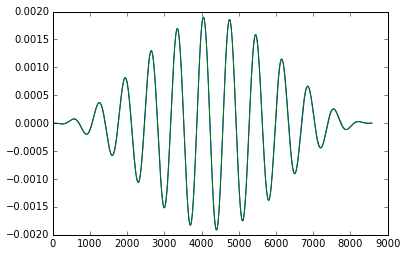

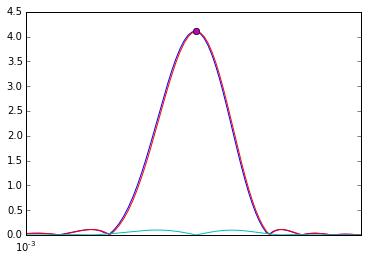

In [745]:
size = waves.shape[-1] * 10
window = sig.hanning(waves.shape[-1])

original = waves[0, 0]
windowed = original * window

fft = np.fft.rfft(windowed, size)
freqs = np.fft.rfftfreq(size)
power = np.abs(fft)
peak = power.argmax()

plt.figure()
plt.plot(windowed)
plt.plot((2 / window.sum()) * construct_wave(fft[peak], freqs[peak], original.size) * window)

plt.figure()

sub_power = subtract_amplitude(power, amplitude=fft[peak], f=freqs[peak], size=size, window=window)

#sub_fft = subtract_amplitude_fft(fft, amplitude=fft[peak], f=freqs[peak], size=size, window=window)
wfft = wave_fft(amplitude=fft[peak], f=freqs[peak], size=size, window=window)
sub_fft = fft - wfft


plt.semilogx(freqs, power)
plt.plot(freqs[peak], power[peak], 'o')
#plt.semilogx(freqs, sub_power)
plt.semilogx(freqs, np.abs(wfft))
plt.semilogx(freqs, np.abs(sub_fft))
plt.xlim(0.001, 0.002)

import scipy.optimize as opt

minim = opt.minimize(minimise_this, 4, args=(fft, freqs[peak], np.angle(fft[peak]), size, window))
print minim.x
plt.plot(freqs[peak], minim.x, 'o')
print power[peak]

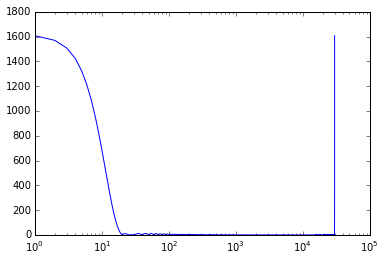

In [657]:
plt.semilogx(np.abs(np.fft.fft(window, 30000)))

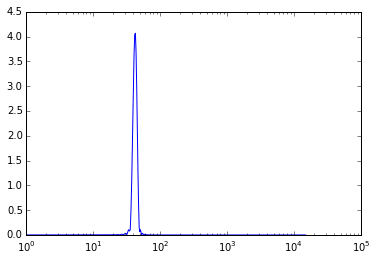

In [662]:
plt.semilogx(np.abs(np.fft.rfft(waves[0, 0] * sig.hanning(waves.shape[-1]), 30000)))

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part


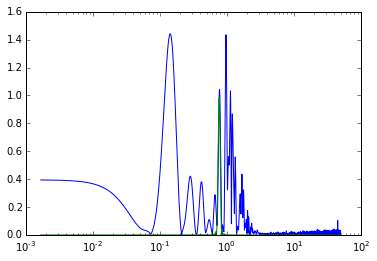

In [668]:
plot_smooth_fft(signal[0])
plot_smooth_fft(waves[5, 0, :3000])

In [ ]:
asignal = r.U[-1, 0, :]

asize = asignal.shape[-1] * 10
awindow = sig.hanning(asignal.shape[-1])

windowed = asignal * awindow
afft = np.fft.rfft(windowed, asize)
afreqs = np.fft.rfftfreq(asize, d=0.01)

(0, 4)

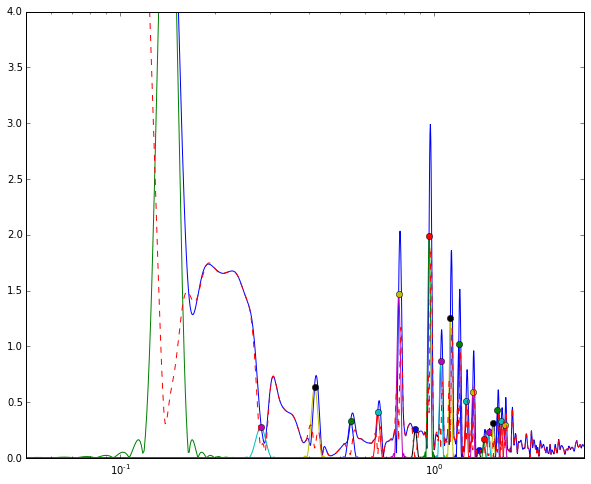

In [1190]:
sub_fft = afft.copy()

plt.figure(figsize=(10, 8))
plt.semilogx(afreqs, np.abs(sub_fft))

amplitudes = np.zeros(standing_frequencies.size, np.complex)
frequencies = np.zeros(standing_frequencies.size, np.complex)
peak_ffts = np.zeros((standing_frequencies.size, afreqs.size), np.complex)

#sorted_peaks = np.abs(fft[np.abs(standing_frequencies[:, None] - freqs).argmin(axis=1)]).argsort()[::-1]

for i, f in enumerate(standing_frequencies[:20]):
    
    amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_all(f, sub_fft, afreqs, asize, awindow, 
                                                                     bounds=(f-0.001,f+0.001))
    #amplitudes[i], frequencies[i], peak_ffts[i] = minimise_power_phase(f, sub_fft, afreqs, asize, awindow)

    sub_fft = sub_fft - peak_ffts[i]
    
    ffit = frequencies[i].real
    
    plt.semilogx(afreqs, np.abs(peak_ffts[i]))
    
    plt.plot(ffit, np.abs(amplitudes[i]), 'o')

plt.semilogx(afreqs, np.abs(sub_fft), 'r--')
plt.xlim(0.05, 3)
plt.ylim(0, 4)

In [1466]:
def minimise_basin(amplitude, fft, f, phase, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_basin(fft, amplitude, f, size, window))

def subtract_amplitude_basin(fft, amplitude, f, size, window):
    return fft - wave_fft(amplitude[:, None], f[:, None], size, window).sum(axis=0)

fbasin = standing_frequencies[:20] * 1.008
idx = np.abs(freqs[:, None] - fbasin).argmin(axis=0)
abasin = np.abs(fft[idx])
pbasin = np.angle(fft[idx])

margs = {'args': (fft, fbasin, pbasin, size, window)}

In [ ]:
minim = opt.basinhopping(minimise_basin, abasin, minimizer_kwargs=margs)

In [1420]:
amp_bounds = [(0, ma) for ma in abasin]

dminim = opt.differential_evolution(minimise_basin,
                                    bounds=amp_bounds,
                                    args = margs['args'])

(0.7, 3)

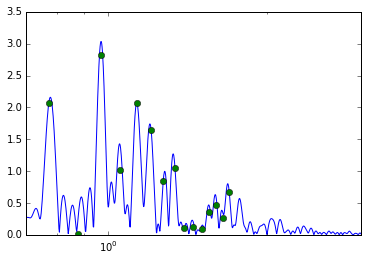

In [1422]:
plt.semilogx(freqs, np.abs(fft))
plt.plot(fbasin, dminim.x, 'o')
plt.xlim(0.7, 3)

In [1425]:
amp_bounds = [(0, ma) for ma in abasin]

mminim = opt.minimize(minimise_basin,
                      x0=abasin,
                      bounds=amp_bounds,
                      args=margs['args'])

(0.1, 3)

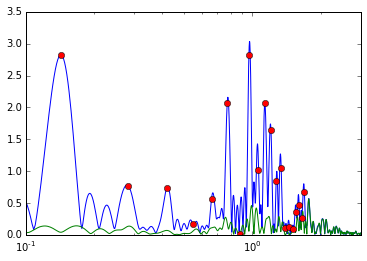

In [1428]:
sub_fft = subtract_amplitude_basin(fft, mminim.x * np.exp(1j * pbasin), fbasin, size, window)

plt.semilogx(freqs, np.abs(fft))
plt.semilogx(freqs, np.abs(sub_fft))

plt.plot(fbasin, mminim.x, 'o')
plt.xlim(0.1, 3)

(0.1, 3)

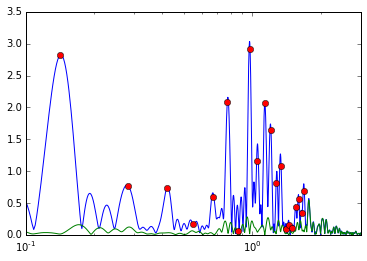

In [1464]:
# what if we use opt.minimize with all variables?

def minimise_basin_all(vector, fft, size, window, n):
    amplitude, phase, f = np.hsplit(vector, 3)
    amplitude = amplitude * np.exp(1j * phase)
    return np.linalg.norm(subtract_amplitude_basin(fft, amplitude, f, size, window))

def subtract_amplitude_basin(fft, amplitude, f, size, window):
    return fft - wave_fft(amplitude[:, None], f[:, None], size, window).sum(axis=0)

n = 20

fbasin = standing_frequencies[:n] * 1.008
idx = np.abs(freqs[:, None] - fbasin).argmin(axis=0)
abasin = np.abs(fft[idx])
pbasin = np.angle(fft[idx])

margs = {'args': (fft, size, window, n)}

bounds = [(0, ma) for ma in abasin] + [(p - 0.1, p + 0.1) for p in pbasin] + [(f - 0.01, f + 0.01) for f in fbasin]

initial = np.hstack((abasin, pbasin, fbasin))

mminim = opt.minimize(minimise_basin_all,
                      x0=initial,
                      bounds=bounds,
                      args=margs['args'])

aout, pout, fout = np.hsplit(mminim.x, 3)

sub_fft = subtract_amplitude_basin(fft, aout * np.exp(1j * pout), fout, size, window)

plt.semilogx(freqs, np.abs(fft))
plt.semilogx(freqs, np.abs(sub_fft))

plt.plot(fout, aout, 'o')
plt.xlim(0.1, 3)

(0, 8)

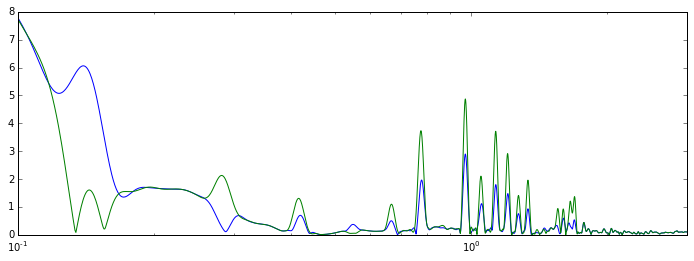

In [1762]:
plt.figure(figsize=(12, 4))
amps = aout * np.exp(1j * pout)
wp = (2 / window.sum()) * construct_wave(amps[:, None], fout[:, None], 8000).real
plot_smooth_fft(r.U[-1, 0, :8000])
plot_smooth_fft(r.U[-1, 0, :8000] - wp.sum(axis=0)[:8000])
plt.xlim(0.1, 3)
plt.ylim(0, 8)

In [1481]:
awindow = sig.hanning(8000)
asize = 65536 * 4

afft = np.fft.rfft(r.U[-1, 0, :8000] * awindow, asize)
afreqs = np.fft.rfftfreq(asize, 0.01)

fbasin = standing_frequencies[5:20] * 1.008

apower = np.abs(afft)

peak = find_closest_peaks(apower, afreqs, fbasin)

fbasin = afreqs[peak]
abasin = np.abs(afft[peak])
pbasin = np.angle(afft[peak])

# use these fbasin, pbasin as truth and find correct amplitudes by minimising
# the presignal

amp_bounds = [(0, ma) for ma in abasin]

window = sig.hanning(3000)
size = 65536
fft = np.fft.rfft(r.U[-1, 0, :3000] * window, size)
freqs = np.fft.rfftfreq(size, 0.01)

margs = {'args': (fft, fbasin, pbasin, size, window)}

mminim = opt.minimize(minimise_basin,
                      x0=abasin,
                      bounds=amp_bounds,
                      args=margs['args'])

(0, 4)

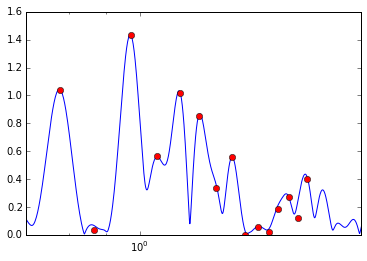

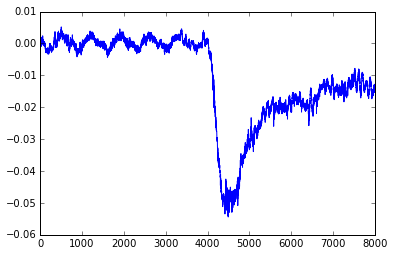

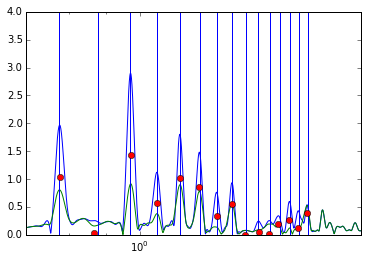

In [1494]:
amps = mminim.x * np.exp(1j * pbasin)

wp = (2 / window.sum()) * construct_wave(amps[:, None], fbasin[:, None], 8000).real

sub_fft = np.fft.rfft((r.U[-1, 0, :8000] - wp.sum(axis=0)) * awindow, asize)

plt.figure()

plt.semilogx(freqs, np.abs(fft))
plt.plot(fbasin, mminim.x, 'ro')
plt.xlim(0.7, 2)

plt.figure()
#plt.plot(wp.sum(axis=0))
plt.plot(r.U[-1, 0, :8000] - wp.sum(axis=0))


plt.figure()

plt.semilogx(afreqs, np.abs(afft))
plt.semilogx(afreqs, np.abs(sub_fft))

#plt.plot(fbasin, abasin, 'o')
plot_all_frequencies(20)
plt.plot(fbasin, mminim.x, 'o')
plt.xlim(0.7, 2)
plt.ylim(0, 4)

(0, 4)

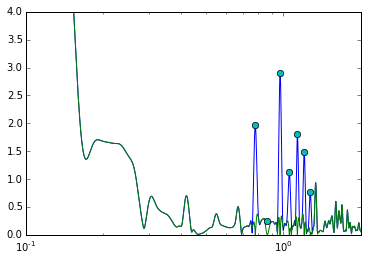

In [1461]:
def minimise_basin(amplitude, fft, f, phase, size, window):
    amplitude = amplitude * np.exp(1j * phase)
    return np.var(np.abs(subtract_amplitude_basin(fft, amplitude, f, size, window)))
    return np.linalg.norm(subtract_amplitude_basin(fft, amplitude, f, size, window))

def subtract_amplitude_basin(fft, amplitude, f, size, window):
    return fft - wave_fft(amplitude[:, None], f[:, None], size, window).sum(axis=0)

awindow = sig.hanning(8000)
asize = 65536 * 2

afft = np.fft.rfft(r.U[-1, 0, :8000] * awindow, asize)
afreqs = np.fft.rfftfreq(asize, 0.01)

fbasin = standing_frequencies[5:12] * 1.008

apower = np.abs(afft)

peak = find_closest_peaks(apower, afreqs, fbasin)
idx = np.abs(afreqs[:, None] - fbasin).argmin(axis=0)

fbasin = afreqs[peak]
abasin = np.abs(afft[peak])
pbasin = np.angle(afft[peak])

margs = {'args': (afft, fbasin, pbasin, asize, awindow)}

amp_bounds = [(0, None) for ma in abasin]

mminim = opt.minimize(minimise_basin,
                      x0=abasin,
                      bounds=amp_bounds,
                      args=margs['args'])

sub_fft = subtract_amplitude_basin(afft, mminim.x * np.exp(1j * pbasin), fbasin, asize, awindow)

plt.semilogx(afreqs, np.abs(afft))
plt.semilogx(afreqs, np.abs(sub_fft))

plt.plot(fbasin, abasin, 'o')
plt.plot(fbasin, mminim.x, 'o')
plt.xlim(0.1, 2)
plt.ylim(0, 4)

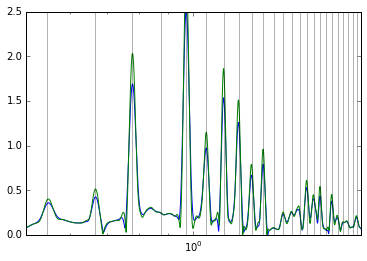

In [1513]:
plot_smooth_fft(r.U[-1, 0], window='blackman')
plot_smooth_fft(r.U[-1, 0], window='hanning')

plt.xlim(0.5, 2)
#plt.yscale('log')
plt.ylim(0, 2.5)
plot_all_frequencies(30, alpha=0.3, color='k')

(0, 0.15)

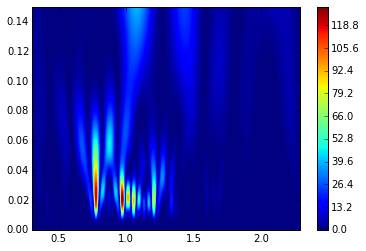

In [1783]:
sfft = np.fft.rfft(r.U[-1, 50, :8000] * sig.blackman(8000, sym=True), 4 * 65536)[800: 6000]
sfreq = np.fft.rfftfreq(65536 * 4, 0.01)[800: 6000]
swt = wavelets.WaveletTransform(np.abs(sfft) - 1, sfreq, dj=0.05, dt=np.diff(sfreq[:2]), wavelet=wavelets.Ricker())

F, S = np.meshgrid(sfreq, swt.scales)

plt.contourf(F, S, swt.wavelet_power, 256)
plt.colorbar()
plt.ylim(0, 0.15)

(0, 2.5)

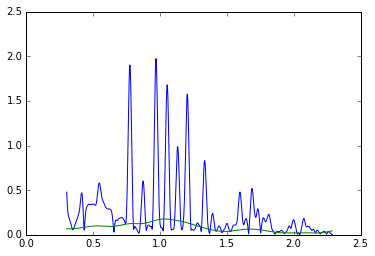

In [1784]:
plt.plot(sfreq, np.abs(sfft))
where = (swt.scales > 0.1) | (swt.scales < 0.01)
where = (swt.scales > 0.08)

plt.plot(sfreq, (1 + swt.reconstruction(swt.scales[where]))* .3)
plt.ylim(0, 2.5)

(0, 0.15)

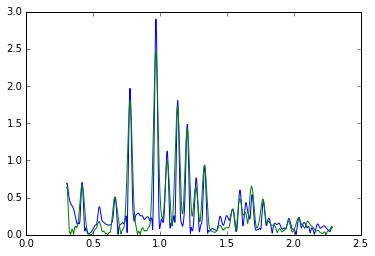

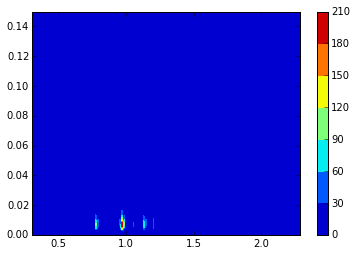

In [1755]:
rswt = wavelets.WaveletTransform(sfft.real, sfreq, dt=np.diff(sfreq[:2]), wavelet=wavelets.Ricker())
iswt = wavelets.WaveletTransform(sfft.imag, sfreq, dt=np.diff(sfreq[:2]), wavelet=wavelets.Ricker())


plt.plot(sfreq, np.abs(sfft))

where = (iswt.scales < 0.1) & (iswt.scales > 0.01)
#where = iswt.scales < 0.001

absr = np.abs(rswt.reconstruction(iswt.scales[where]) + 1j * iswt.reconstruction(iswt.scales[where]))

plt.plot(sfreq, 5 * absr)
#plt.ylim(0, 2.5)
#plt.plot(sfreq, sfft.imag)

plt.figure()

F, S = np.meshgrid(sfreq, iswt.scales)

plt.contourf(F, S, iswt.wavelet_power)
plt.colorbar()
plt.ylim(0, 0.15)

In [1787]:
asfft = np.fft.rfft(r.U[-1, :, :8000] * sig.hanning(8000), 4 * 65536, axis=-1)[:, 800: 6000]
asfreq = np.fft.rfftfreq(65536 * 4, 0.01)[800: 6000]

aswt = wavelets.WaveletTransform(np.abs(asfft), asfreq, dj=0.05, dt=np.diff(asfreq[:2]), axis=-1, wavelet=wavelets.Ricker(), frequency=True)

AttributeError: 'WaveletTransform' object has no attribute 'shape'

<matplotlib.contour.QuadContourSet instance at 0x2aff9004ff80>

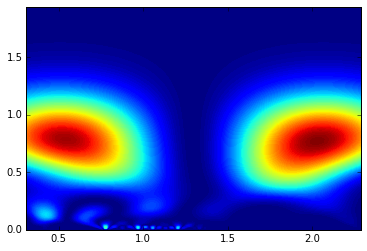

In [1786]:
F, S = np.meshgrid(aswt.time, aswt.scales)

plt.contourf(F, S, aswt.wavelet_power, 100)

In [1790]:
where = aswt.scales > 0.1
ra = aswt.reconstruction(aswt.scales[where])

<matplotlib.contour.QuadContourSet instance at 0x2aff90308830>

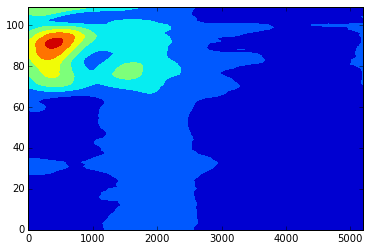

In [1792]:
plt.contourf(ra)

In [1611]:
ricker = wavelets.Ricker()(np.linspace(-4, 4, 100))
ricker.min() / ricker.max()
0.44**2

0.1936

(0, 8)

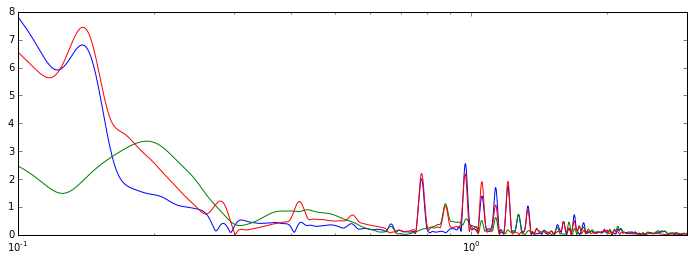

In [1168]:
plt.figure(figsize=(12, 4))

hf = r.U[-1, :, :8000].mean(axis=0)

plot_smooth_fft(r.U[-1, 10, :8000])
plot_smooth_fft(r.U[-1, 10, :8000] - hf)
plot_smooth_fft(hf)
plt.xlim(0.1, 3)
plt.ylim(0, 8)

Another idea:

use the ps of the presignal to obtain the amplitudes

use the ps of the full signal to get the frequencies and phase

use the boxcar window to get good frequency resolution

use the presignal to obtain the first few modes that are obscured by the background

using the frequencies and phase from the fullsignal peaks, find the amplitude by minimising the presignal


And another:

low pass filter the ps of the full signal to remove the peaks.


(0, 8)

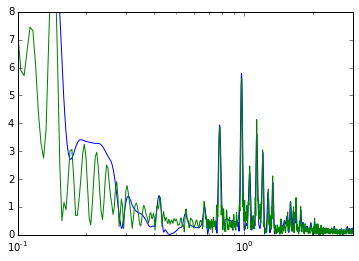

In [1167]:
plot_smooth_fft(r.U[-1, 0, :8000] * 1 / np.hanning(8000).mean())
plt.semilogx(np.fft.rfftfreq(30000, d=0.01), np.abs(np.fft.rfft(r.U[-1, 0, :8000], 30000)))
plt.xlim(0.1, 3)
plt.ylim(0, 8)

(0.1, 3)

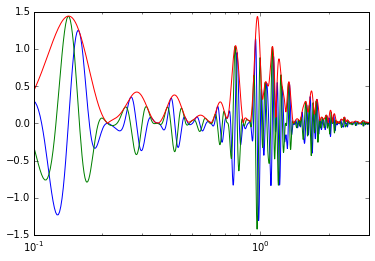

In [1173]:
plt.semilogx(freqs, fft.real)
plt.semilogx(freqs, fft.imag)
plt.semilogx(freqs, np.abs(fft))

plt.xlim(0.1, 3)

(0.5, 2)

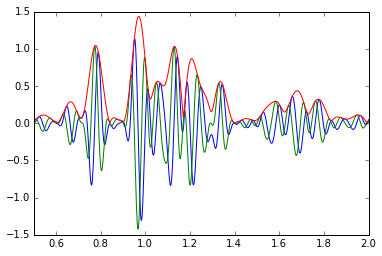

In [1184]:
plt.plot(freqs, fft.real)
plt.plot(freqs, fft.imag)
plt.plot(freqs, np.abs(fft))

plt.xlim(0.5, 2)

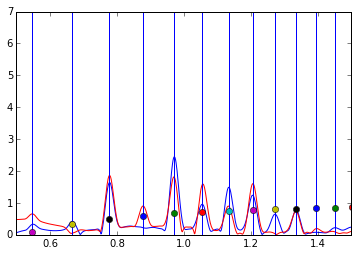

In [1412]:
# the length of signal that we take really varies the resolution of the peaks.
# try changing 8000 to 4000/3000 here
ffft = np.fft.rfft(r.U[-1, 0, :8000] * sig.blackman(8000), 65536)
ffreqs = np.fft.rfftfreq(65536, d=0.01)

ffft2 = np.fft.rfft(r.U[-1, :, :8000] * sig.blackman(8000), 65536, axis=-1)


plt.plot(ffreqs, np.abs(ffft))
plt.plot(ffreqs, np.abs(ffft2.mean(axis=0)), 'r')
#plt.plot(ffreqs, np.angle(ffft) + 3, '.')

plt.xlim(0.5, 1.5)
plt.ylim(0, 7)

plot_all_frequencies(25)

for f in standing_frequencies[:25] * 1.008:
    plt.plot(f, np.abs(np.cos(k(f) * x)).mean(), 'o')

win = sig.blackman(200)
#plt.plot(ffreqs[200:], np.convolve(win / win.sum(), np.abs(ffft[200:]), mode='same'), 'k', linewidth=3)

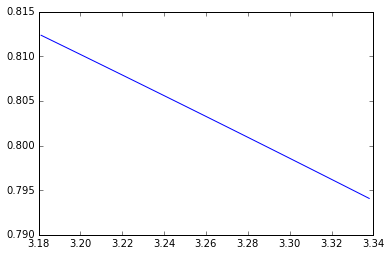

In [1418]:
plt.plot(x, np.cos(k(standing_frequencies[11] * 1.008) * x))

In [2126]:
fffta = np.fft.rfft(r.U[:, :, :8000].mean(axis=0) * sig.hamming(8000), 65536, axis=-1)

(0, 3)

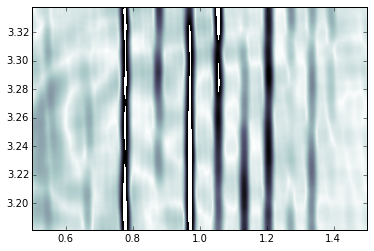

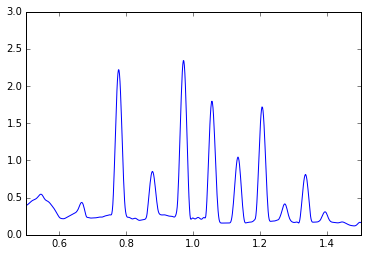

In [2112]:
x = r.X[0, :, 0]
Ff, Xf = np.meshgrid(ffreqs, x)
plt.contourf(Ff, Xf, np.abs(fffta), levels=np.linspace(0, 2, 200), cmap=plt.cm.bone_r)
plt.xlim(0.5, 1.5)

plt.figure()
plt.plot(ffreqs, np.abs(fffta).mean(axis=0))

plt.xlim(0.5, 1.5)
plt.ylim(0, 3)

fullsignal at x without much happening -> frequencies / phase

using these frequencies, find *combination* of phase / amplitudes that minimises the power spectrum of the presignal for each x

In [1203]:
print ffreqs.shape
print ffft.shape
bandpass(np.abs(ffft), 0, 0.1).shape

(32769,)
(32769,)


(32768,)

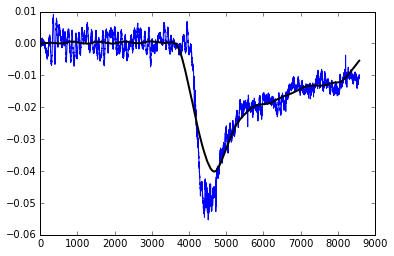

In [1236]:
plt.plot(asignal)
win = sig.gaussian(1000, 500)
plt.plot(np.convolve(win / win.sum(), asignal, mode='same'), color='k', linewidth=2)

Perhaps we can use the full signal to get the peaks out:

1. Remove the biggest standing wave peaks (first 4 or so), using presignal.

2. Smooth the remaining signal.

3. Subtract smoothed signal from original.

4. Take power spectrum of subtraction.

Alternately:

1. Remove biggest standing waves

2. Transform to FRONT and average.

3. Subtract front average from transformed original

4. Transform back to LAB.

5. Take power spectrum of lab subtraction.

0.0608582


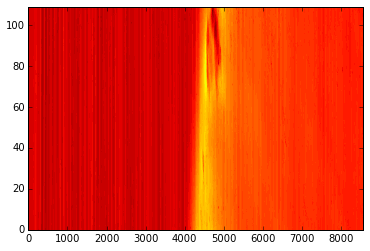

In [1315]:
import scipy.ndimage as ndi

print r.front_speed.value

plt.contourf(r.U[-1, :, :], 100)

dx = r.X[0, 1, 0] - r.X[0, 0, 0]
shear = 1 / (r.front_speed.value * r.dt / dx)

A = np.array([[1, 0],
              [shear, 1]])

tr = ndi.affine_transform(r.U[-1, :, :], A, order=0)

<matplotlib.contour.QuadContourSet instance at 0x2afd48036368>

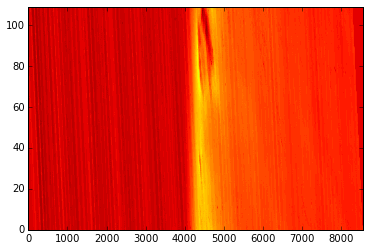

In [1264]:
plt.contourf(tr, 100)

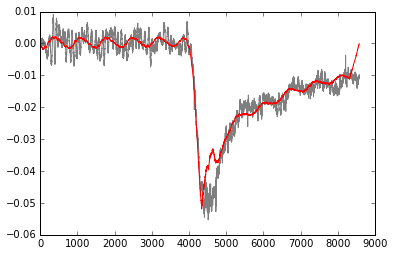

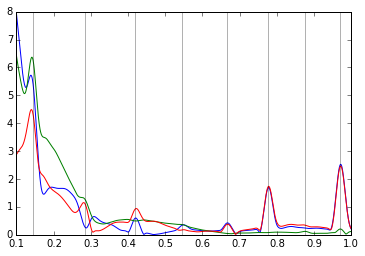

In [1313]:
mtr = tr[:].mean(axis=0)

plt.plot(r.U[-1, 0], 'k', alpha=0.5)
plt.plot(mtr, 'r')


plt.figure()
plot_smooth_fft(r.U[-1, 0], 'blackman')
plot_smooth_fft(mtr)
plot_smooth_fft(r.U[-1, 0] - mtr, 'blackman')


plt.xlim(0.1, 1)
plt.ylim(0, 8)
plt.xscale('linear')
plot_all_frequencies(20, color='k', alpha=0.3)

In [1969]:
def plot_smooth_fft(signal, **kwargs):
    window = kwargs.pop('window', 'hanning')
    window = sig.get_window(window, signal.size, fftbins=False)
    
    fft = np.fft.rfft(signal * window, signal.size * 20)
    freqs = np.fft.rfftfreq(signal.size * 20, d=0.01)
    power = np.abs(fft)
    
    plt.semilogx(freqs, power, **kwargs)

(0, 0.5)

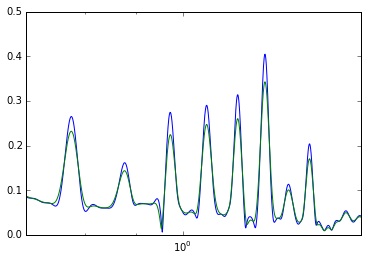

In [1306]:
plot_smooth_fft(mtr)
plot_smooth_alt(mtr, window='blackman')
plt.xlim(0.7, 1.5)
plt.ylim(0, 0.5)

In [1793]:
Aa = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, shear, 1]])

tra = ndi.affine_transform(r.U[:, :, :], Aa, order=0, cval=np.nan)

<matplotlib.contour.QuadContourSet instance at 0x2aff1b50ac20>

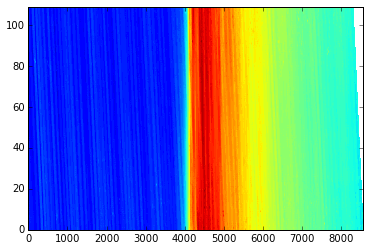

In [1794]:
plt.contourf(tra[10, :, :], 100)

In [1798]:
mtra = tra.mean(axis=1, keepdims=1)

<matplotlib.contour.QuadContourSet instance at 0x2aff1e0770e0>

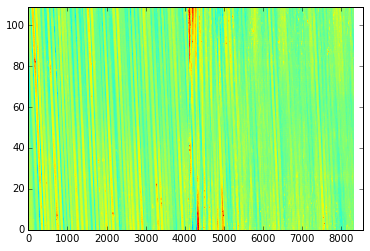

In [1799]:
plt.contourf((tra - mtra)[10], 100)

In [1805]:
iAa = np.array([[1, 0, 0],
                [0, 1, 0],
                [0, -shear, 1]])

In [1806]:
m_sub = ndi.affine_transform(tra - mtra, iAa, order=0, cval=np.nan)

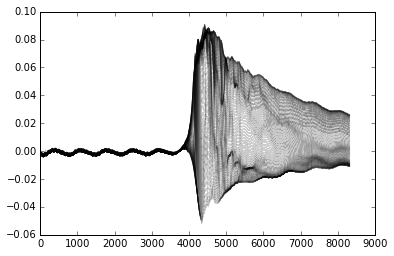

In [1845]:
imtra = ndi.affine_transform(mtra, iAa, order=0, cval=np.nan)
plt.plot(imtra.squeeze().T, 'k', alpha=0.2);

<matplotlib.contour.QuadContourSet instance at 0x2b0375c97998>

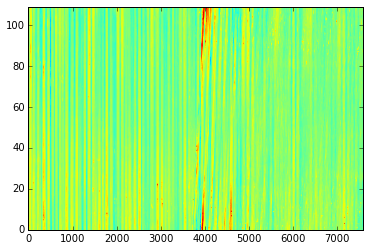

In [2122]:
plt.contourf(m_sub[10, :, 400:8000], 100)

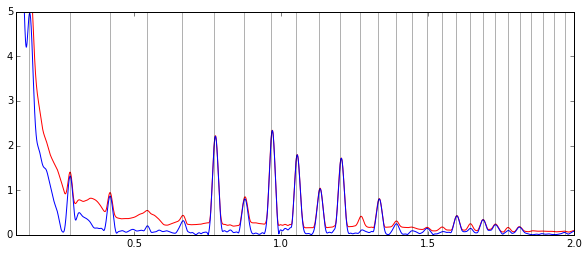

In [2035]:
plt.figure(figsize=(10, 4))

#plt.plot(ffreqs, fffta.max(axis=0), 'r', alpha=0.5)
#plt.plot(ffreqs, np.abs(fffta.T), color='k', alpha=0.2);
#plt.plot(ffreqs, (np.abs(fffta) ** 2).mean(axis=0), color='g')
plt.plot(ffreqs, (np.abs(fffta)).mean(axis=0), color='r')

#mfft = np.fft.rfft(m_sub[:, :, 400:8400].mean(axis=0).mean(axis=0) * sig.blackman(8000), 65536)
#plt.plot(ffreqs, np.abs(mfft))
plot_smooth_fft(r.U[:, :, :8000].mean(axis=0).mean(axis=0), window='hamming', color='b')

#plot_smooth_fft(np.nanmean(np.nanmean(m_sub[:, :, 4:8004], axis=0), axis=0), window='hamming', color='g')



#plot_smooth_fft(construct_wave(0.001, standing_frequencies[7] * 1.008, r.U.shape[-1]), window='blackman')

plot_all_frequencies(30, color='black', alpha=0.3, scaling=1.005)
plt.xlim(0.1, 2)
plt.ylim(0, 5)
plt.xscale('linear')

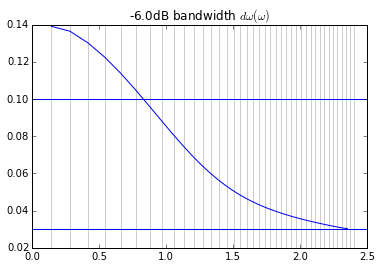

In [2034]:
def dw(n):
    H = 0.25
    g = 9.81
    L = 5.50
    
    r = np.pi / L
    hnr = H * n * r
    A = g * r * (hnr * 1 / np.cosh(hnr) ** 2 + np.tanh(hnr))
    B = 2 * (g * n * r * np.tanh(hnr)) ** .5
    return A / B

#plt.plot(dw(np.arange(1, 30)))
N = np.arange(1, 40)
W = full_frequency(N)
plt.plot(W, np.gradient(W))

plt.title(r'-6.0dB bandwidth $d\omega(\omega)$')

plot_all_frequencies(40, color='k', alpha=0.2)

plt.axhline(0.1)   # blackman 3000 point
plt.axhline(0.03)  # blackman 8000 point

<matplotlib.colorbar.Colorbar instance at 0x2b03107617a0>

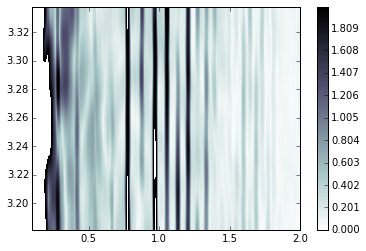

In [2027]:
Ff, Xf = np.meshgrid(ffreqs, x)
plt.contourf(Ff, Xf, ndi.convolve1d(np.abs(fffta), sig.boxcar(20) / sig.boxcar(20).sum(), axis=0), levels=np.linspace(0, 2, 200), cmap=plt.cm.bone_r)
plt.xlim(0.1, 2)
plt.colorbar()

In [ ]:
find closest peaks in abs(fffta).mean(axis=0)

what is frequency / phase of these?

use this frequency / phase as given.

now extract the amplitude variation (x) from np.abs(fffta)[peaks]

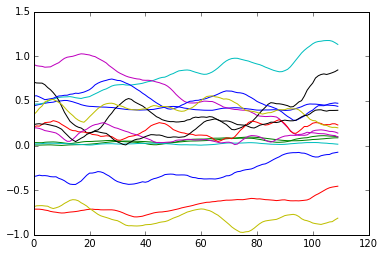

In [2201]:
def find_closest_peaks(power, freqs, guess_freqs):
    """Given a power spectrum over frequencies `freqs` 
    find the array indices of the power spectrum peaks 
    closest to the guess_freqs.
    """
    # find the maxima in the power spectrum
    maxima = sig.argrelextrema(power, np.greater)

    maxima_freqs = np.zeros(freqs.shape)
    maxima_freqs[maxima] = freqs[maxima]
    
    # determine the peaks as the closest maxima to each of the standing wave frequencies
    peak_indices = [find_nearest_idx(maxima_freqs, f) for f in guess_freqs]
    return peak_indices

fffta = np.fft.rfft(r.U[10:, :, :8000].mean(axis=0) * sig.hamming(8000), 65536, axis=-1)

all_peaks = sig.find_peaks_cwt(-np.abs(fffta).mean(axis=0), np.linspace(0.01, 0.05))

peaks = find_closest_peaks(np.abs(fffta).mean(axis=0), ffreqs, standing_frequencies[5:20] * 1.005)

pf = ffreqs[peaks]
pp = np.angle(fffta).mean(axis=0)[peaks]

pax = np.abs(fffta)[:, peaks]

amplitudes = pax * np.exp(1j * pp[None, :])

plt.plot(amplitudes);

0.869782871234


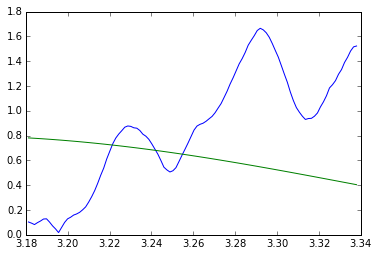

In [2195]:
plt.plot(x, pax[:, 0])
print standing_frequencies[6]

r = 0.999999
swe = 1 + r ** 2 + 2 * r * np.cos(2 * np.pi * 7 * x / L)
plt.plot(x, 0.2 * swe)

(0, 2)

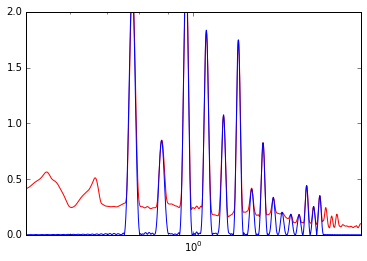

In [2209]:
wp = (2 / sig.hamming(8000).sum()) * construct_wave(amplitudes[..., None], pf[None, :, None], 8000).real.sum(axis=1)

plt.plot(ffreqs, (np.abs(fffta)).mean(axis=0), color='r')
plot_smooth_fft(wp.mean(axis=0), window='hamming')
plt.xlim(0.5, 2)
plt.ylim(0, 2)

(0, 2)

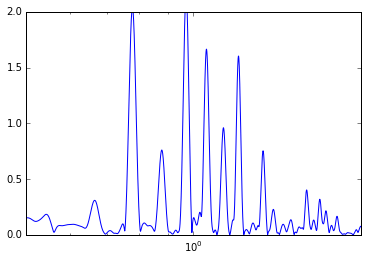

In [2222]:
not_peak = np.abs(np.fft.rfft(wp * sig.hanning(8000), 65536, axis=-1)).mean(axis=0) < 0.1
ffftac = fffta.copy()
ffftac[:, not_peak] = 0
#plt.plot(ffreqs, np.abs(ffftac).mean(axis=0))

rwp = np.fft.irfft(ffftac, axis=-1, n=8000)

plot_smooth_fft((r.U[10:, :, :8000].mean(axis=0) - rwp).mean(axis=0))
plt.xlim(0.5, 2)
plt.ylim(0, 2)

(0, 2)

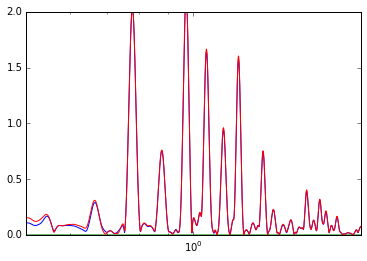

In [2225]:
plot_smooth_fft((r.U[:, :, :8000].mean(axis=0)).mean(axis=0))
plot_smooth_fft(rwp.mean(axis=0))
plot_smooth_fft((r.U[10:, :, :8000].mean(axis=0) - rwp).mean(axis=0))
plt.xlim(0.5, 2)
plt.ylim(0, 2)

TypeError: long() argument must be a string or a number, not 'slice'

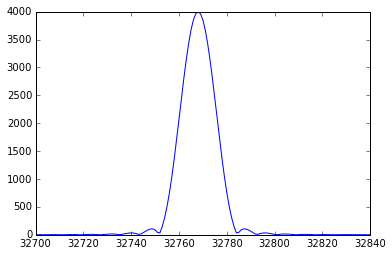

In [2072]:
plt.plot(np.fft.fftshift(np.abs(np.fft.fft(sig.hanning(8000), 65536))))
plt.xlim(32700, 32840)

plt.figure()
plt.plot(np.abs(np.fft.fft(sig.hanning(8000), 65536).take()))

(0, 2)

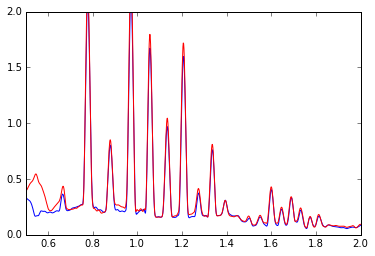

In [2130]:
ffftam = np.fft.rfft(np.nanmean(m_sub[:, :, 400:8300], axis=0) * sig.hamming(7900), 65536, axis=-1)
plt.plot(ffreqs, np.abs(ffftam).mean(axis=0))
plt.plot(ffreqs, np.abs(fffta).mean(axis=0), color='r')

plt.xlim(0.5, 2)
plt.ylim(0, 2)

(0, 2)

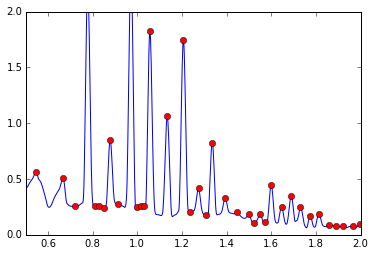

In [2160]:
peaks = sig.find_peaks_cwt(-np.abs(fffta).mean(axis=0), np.linspace(0.02, 0.03))
plt.plot(ffreqs, np.abs(fffta).mean(axis=0))
plt.plot(ffreqs[peaks], np.abs(fffta).mean(axis=0)[peaks], 'ro')

plt.xlim(0.5, 2)
plt.ylim(0, 2)

In [2154]:
sig.find_peaks_cwt?